In [1]:
import pandas as pd
import re
import pytz
import pandas as pd
from collections import Counter
from difflib import SequenceMatcher

In [2]:
# Read the list of filenames from the configuration file
with open('../file_list.txt', 'r', encoding='utf-8') as config_file:
    file_names = config_file.read().splitlines()

# Regex pattern to match the data format
pattern = r'\[(.*?)\] (.*?): (.*)'

# Initialize an empty list to store parsed data
datalist = []
stream_count = 0
# Iterate over each specified file
for file in file_names:
    full_path = f"../data/{file}"
    with open(full_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            match = re.match(pattern, line)
            if match:
                date, user, message = match.groups()
                datalist.append([date, user, message,stream_count])
    stream_count = stream_count + 1



KeyboardInterrupt: 

In [ ]:
# Create a DataFrame from the parsed data
data = pd.DataFrame(datalist, columns=["date", "user", "message","stream"])
data['date'] = pd.to_datetime(data['date'])



In [ ]:
def convert_utc_to_cet(df, date_column='date'):
    
    # Make a copy to avoid modifying the original
    df = df.copy()
    
    # Ensure timestamps are UTC aware
    if df[date_column].dt.tz is None:
        df[date_column] = df[date_column].dt.tz_localize('UTC')
    elif df[date_column].dt.tz != pytz.UTC:
        df[date_column] = df[date_column].dt.tz_convert('UTC')
    
    # Convert to CET/CEST (Europe/Berlin includes proper DST handling)
    df[date_column] = df[date_column].dt.tz_convert('Europe/Berlin')
    
    return df

data = convert_utc_to_cet(data)

In [ ]:
seventvlis = ['arnoldHalt',
 'SEXO',
 'peepoMarch',
 'doroHEAD',
 '4stars',
 'Rizzler',
 'ppL',
 'WAIT',
 'SpeedLaugh',
 'GetALoadOfThisGuy',
 'ModAbuse',
 'DoroCheer',
 'BHOP',
 'WhoAsked',
 'SCRAPETHATSHITJOHNNY',
 'OverwhelminglyWholesome',
 'SAJ',
 'NOW',
 'LETSFUCKINGJOE',
 '3stars',
 'aga',
 'ome47',
 'OMEGALUL',
 'Gayge',
 'peepoFat',
 'HolyFuck',
 'RAHH',
 'SNIFFA',
 'xdd',
 'EDGE',
 'LetsBingo',
 '!lurk',
 'Caught',
 'monakS',
 'ahmadmuhsin',
 'wade',
 'parasocial',
 'EdwardStare',
 'ISeeYou',
 'YouWouldntGetIt',
 'Banties',
 'DRAIN',
 'banties',
 'PepeHands',
 'WidelebronJAM',
 'Lamonting',
 'CAUGHT',
 'LOL',
 'FeelsDankMan',
 'pepeJAM',
 'ayo',
 '!unfollow',
 'glorp',
 'Waiting',
 'owoshy',
 'wideduckass',
 'HELLO',
 'Pepega',
 'DeathIncoming',
 'brbToilet',
 'ads',
 'despair',
 'TWEAK',
 'sus',
 'THINKING',
 'bruv',
 'ROFL',
 'juh',
 'skip',
 'OuttaPocket',
 'RareParrot',
 'emergencylandingstrip',
 'FirstTimePepega',
 'WideCatGroove',
 'Clueless',
 'ADHD',
 'StoryTime',
 'Delusional',
 'firewriting',
 'ragebait',
 'Aloo',
 'ome15',
 'peepoHug',
 'PagMan',
 'Based',
 'OMFG',
 'PepegaAim',
 'VeryPog',
 'OVERWORKING',
 'LL',
 'myIQ',
 'doroFiddy',
 'MUGA',
 'SAVEME',
 'GotEEM',
 'PagChomp',
 'Surfing',
 'PokiShare',
 'FEINFEINFEINFEINFEINFEINFEINFEI',
 'FeelsLagMan',
 'flowerr',
 'speed1',
 'NAUR',
 'BINGO',
 'STREAMERSGIVINGTHEWORSTFUCKINGTAKESINEXISTENCE',
 'gothKiss',
 'WAYTOODANK',
 'ppOverheat',
 'ManchesterUnited',
 'dogJAM',
 'ewphop',
 'fortnite',
 'Doc1v1',
 'GotCaughtTrolling',
 'nonono',
 'dash',
 'veryDoro',
 'YAPPING',
 '!boost',
 'Bleh',
 'Sadge',
 'GIGAMOD',
 'dudWhat',
 'gPls',
 'YANITED',
 'Alarm',
 'WHOAAA',
 'HOLY',
 'TheVoices',
 'PokiShareW',
 'SpeedR',
 'RoxyPotato',
 'STREAMER',
 'emo2',
 'WatchingStream',
 'POVbornbefore2000',
 'lemon',
 'RaveTime',
 'dome44',
 'shutup',
 'ome55',
 'gg',
 'typeshit',
 'peepoLeave',
 'Paul',
 'unibrow',
 'GRRR',
 'lebronArrive',
 'DoroTalkingAgain',
 'ome29',
 'CrayonTime',
 'ANOTHERONE',
 'saythatagain',
 'monkaW',
 'peepoHey',
 'ONEMORE',
 'Considering',
 'Explosion',
 'LULE',
 'peepoKiss',
 'Joel',
 'CLOWNDETECTED',
 'ChillGuy',
 'Exerpas',
 'walterShocked',
 'ohneFinger',
 'SteerR',
 'lebronJAM',
 '+1',
 'EZdodge',
 'CLEAN',
 'ogo',
 'yesbro',
 'BantiesPaulBeef',
 'WalterVibe',
 'SOYSCREAM',
 'Pffttt',
 'WW',
 'VeryKey',
 'ome14',
 'spongePls',
 'Bello',
 'bieberDougie',
 'MODDING',
 ':tf:',
 'heyywithrizz',
 'HowDoWeTellHer',
 'sdd',
 'plinkVibe',
 'omeClap',
 'xJAM',
 'RussiaPls',
 'DRAMA',
 'firsttimebuh',
 'AINTNOWAY',
 'BUSSIN',
 'TriJam',
 'Modding',
 'WePaid',
 'Loading',
 'wideSpeedLaugh3',
 'ome104',
 'goblin44',
 'CaughtIn4K',
 'omEE',
 '0pixel',
 'arthur',
 'xqcL',
 'Borfday',
 'jacob3',
 '4Weird',
 'bah',
 'RealForsen',
 'BOOBA',
 'doroMAD',
 '5Head',
 'xqcTwerk',
 'Ohh',
 'peepoDJ',
 'HeDisconnected',
 'SCHEISSE',
 'scawy',
 'hi',
 'Drake',
 'RIPBOZO',
 'GAMBA',
 'RightThere',
 'JermaSoy',
 'wig',
 'WHOLETHERSLAY',
 'RAGEY',
 'peepoShy',
 'AIWITHTHEBRAIDS',
 'lurkk',
 'PepegaChat',
 'YeahThatsWhatIWouldaDid',
 'catDespair',
 'FellOff',
 'WIDEALERT',
 'Plotge',
 'mods',
 'Parasocial',
 'WakeTheFuckUpSamuraiWeHaveACityToBurn',
 'brb',
 'hackingCD',
 'luton',
 'heh',
 'BELIEVERS',
 'mhm',
 'Flirt',
 'PTSD',
 'LieMeter',
 'THIS',
 'uuh',
 'doroGHOST',
 'niceguy',
 'TriSad',
 'catSigh',
 'RememberTheDays',
 'OLDWORK',
 '(7TV)',
 'LookUp',
 'weirdChamp',
 'peepoTalk',
 'helvete',
 'EDITING',
 'OVERWATCH',
 'JESSE',
 'amongE',
 'COMEHERE',
 'MeRN',
 'emo',
 'Chatting',
 'goaler',
 'catJAM',
 'biteof87',
 'winton',
 'Looking',
 'om',
 'TRUEING',
 'peepoHappy',
 'VIDEOGAME',
 'justinbieber',
 'pickle',
 'SurE',
 'SLAY',
 'YAAY',
 'merch',
 'unmod',
 'GULP',
 'reckH',
 '5stars',
 'NoMaidens',
 'pepeW',
 'Sippin',
 'totallylistening',
 'WaitingForLove',
 'BANGER',
 'D:',
 'Dave',
 'WAHHH',
 'PepegaReading',
 'Steve',
 'forsenPls',
 'dome32',
 'OMEYES',
 'Jammies',
 'Listening',
 'GlorpMeeting',
 'glorprave',
 ':33',
 'BatChestAbove',
 'sisyphus',
 'BORGIR',
 'peepoPride',
 'NOIDONTTHINKSO',
 'INTENSEGAMING',
 '!drop',
 'lore',
 'NAHHHH',
 'phpk',
 'ImtiredBoss',
 'oopsie',
 'ok',
 'MAJ',
 'KKalinka',
 'FeelsWeirdMan',
 'NAvsEU',
 'ome101',
 '3Heading',
 'vibePls',
 'GoodTake',
 'ome105',
 'Yooo',
 'ome99',
 'omeStare',
 'LastTimeChatter',
 'Cinema',
 'HARAM',
 'Devious',
 'WideRaveTime',
 'Yoink',
 'AAAAAAAAUHGGH',
 'StreamEnding',
 'Johnporkiscalling',
 'SCHIZO',
 'FirstTimeChatter',
 'Waddup',
 'catBusiness',
 'modCheck',
 'FeelsStrongMan',
 'CatTime',
 'PianoTime',
 'FLASHBANG',
 'OOOO',
 'Susge',
 'nuhuh',
 'SUSSY',
 'NAILSING',
 'classic',
 'deadassFaint',
 'chatters',
 'ome44',
 'HABIBI',
 'ryanArrive',
 'joever',
 'Cuck',
 'pepeGun',
 'midloud',
 'LOCKIN',
 'ome32',
 'FARMING',
 'Scared',
 'matSad',
 'BEGGING',
 'GotCaughtCheating',
 'poroPls',
 'PepePls',
 'Sits',
 'sotruebestie',
 'Tuckge',
 'onggang',
 'widetime',
 'vas',
 'OneGuy',
 'HELP',
 'gkeywide',
 'life',
 'freddy',
 'GoodBye',
 'ome69',
 'AAAA',
 'AURA',
 'omeJudging',
 'doggoSlava',
 'GIGACHAIR',
 'pKitten',
 'SADge',
 'MYLIFE',
 'YouGotMe',
 'buhFlipExplode',
 'peepoSmile',
 'ome18',
 'glorpdetective',
 'Flushed',
 'Reacting',
 'peepoSad',
 'agahi',
 'AlienPls',
 'MODS',
 'characterSelected',
 'PotFriendDance',
 'Hmm',
 'MyExistenceIsNothingButAGrainOfSandComparedToTheEntireScaleOfTheUniverse',
 'FUNNY',
 'Barry63',
 'forsenCD',
 'SpeedL',
 'Jay',
 'GOONING',
 'gkitten',
 'omeJAM',
 'FeelsLateMan',
 'wot',
 'bog',
 'WideHUH',
 '1star',
 'MeWhenIBuyEgyptianProperty',
 'xqc32',
 'smh',
 'Pipege',
 'SERIOUSLY',
 ':3',
 'doroKick',
 'peepoRiot',
 'Whenyourinnerwolfreleases',
 'nanaAYAYA',
 'catSmash',
 'catKISS',
 'RIRI',
 'SCORN',
 'IMGOINGINSANEANDCOMPLETELYLOSINGITAAAAAAAAAAAHHHHHHH',
 'happi',
 'KEKW',
 'jacob2',
 'NAHH',
 'NOCHECKMARKS',
 'YESS',
 'buh',
 'EZ',
 'POLICE',
 'BaileyChamp',
 'peepoDoubters',
 'WeDoNotCare',
 'cokeBreak',
 'peepoComfy',
 'doroJAM',
 'ReallyMad',
 'ohhh',
 'KaiCenatOhiogyatwithskibiditoiletwatchingtheWrizzhappeningrightinfrontofhimwithfanumtaxtaxingthegyat',
 'pepeAgony',
 'xqcDespair',
 'bye',
 'WineTime',
 'test',
 'IFISPEAK',
 'HUH',
 'LittleTrolling',
 'axeIF',
 'GIGACLAUS',
 'Staring',
 'ratio',
 'unemployment',
 '44emo',
 'notxqcL',
 'barack',
 'imback',
 'itsover',
 'LiterallyMe',
 'Pointless',
 'BUSSERS',
 'Broadcaster',
 'catTwerk',
 'KanyeStare',
 'peepoLegs',
 'Dentge',
 'Peace',
 'Reddit',
 'Panam',
 'drooling',
 'NOSHOT',
 'EldenRoll',
 'LiveReaction',
 'LETHERCOOK',
 'iDrive',
 'Gooner',
 'JokerHAHA',
 'LETSGO',
 'okak',
 'DOCBOZO',
 'MARIO',
 'Clap2',
 'ome41',
 'PARASOCIAL',
 'GODDID',
 'YOOLOOKATTHISCATDOINITSLILDANCYDANCEINTOABREAKDANCEMOVE',
 'Shruge',
 'MicTime',
 'WasZumPenis',
 'VibePls',
 'docAwaken',
 'batPls',
 'homelessPOV',
 'plonk',
 'UltraMad',
 'noonecares',
 'Tomfoolery',
 'COPIUM',
 'DrDisrespect',
 'Please',
 'FeelsGladMan',
 'ome96',
 'MONKE',
 'PAUSENEMOGU',
 'essaying',
 'WHOLETHERCOOK',
 'ratomilton',
 'ohno',
 'Prayge',
 'freakbob',
 'Madge',
 'peepoEvil',
 'WAJAJA',
 'hue',
 'xqcGoofy',
 'BigD',
 'ThePaulers',
 'EEK',
 'freakyfredday',
 'wallE',
 'JumpScared',
 'GENIUS',
 'WidezyzzPls',
 '!play',
 'KENOUGH',
 'DogLookingWickedAndCool',
 'raid',
 'Clown',
 'TriKool',
 'FINALLY',
 'zyzzJAM',
 'o7',
 'Batman',
 'Dime',
 'qq',
 'iAsked',
 'OMEGALULiguess',
 'CLIPPERS',
 'ApuApustaja',
 'HandsUp',
 'fnaf',
 'MEGALUL',
 'Wisdom',
 'Swag',
 'Enough',
 'girlBoss',
 'MONKA',
 'gooner',
 'giancarlo',
 'Noppers',
 'ZhongXina',
 'lockedin',
 'AlienDance',
 'Cyat',
 'peepoBelievers',
 'peepoClap',
 'Gaught',
 'catPls',
 'CS2',
 'VIEWERS',
 'JustAChillGuy',
 'GAGAGA',
 'omE',
 'ome52',
 'FristTime',
 ':0',
 'BOOM',
 'Stare',
 'chilling',
 'notListening',
 'Thinking',
 'NOTED',
 'YOOOLOOKATTHISCOCKWITHDADRIPSHII',
 'nymnCorn',
 'Ant',
 'barryArrive',
 'UGH',
 '2stars',
 'JARVIS',
 'gigl',
 'CatEat',
 'xqcBOZO',
 '1DLove',
 '!join',
 'jah',
 'KKonaW',
 'ThisChat',
 'WDYM',
 'RainTime',
 'AWOO',
 'batman',
 'KKool',
 'OHMYGAWDD',
 'LULW',
 'Clap',
 'fein',
 'WELSH',
 'otag',
 'Chillin',
 'spfLEAN:()wiltee_()tonyhawkproskater4:-:-:_FREEWAVE3-encinoman--:enteringwalmart:-wheezethelean-123',
 'peepoGiggles',
 'War',
 'nt',
 'YamesBond',
 'crabPls',
 'GAMING',
 'BASED',
 'catAsk',
 'forsenLaughingAtYou',
 'OMEGADANCE',
 'pleading',
 '3Head',
 'Evilge',
 'FeelsBlackScreen',
 'GYAT',
 'AreYouSeriousRightNeow',
 'GIGACHAD',
 'silliness',
 'HowDoWeTellHim',
 'ANGRE',
 'MYMAINGOAL',
 'pL',
 'PEEPEES',
 'Dorozea',
 'zyzzBass',
 'FeelsOkayMan',
 'doroAunt',
 'YOUDIED',
 'steve',
 'Bloons',
 '1984',
 'xQcVeryWide',
 'FirstTimeBackseating',
 'xqcScHIZO',
 'pepePoint',
 'PogU',
 'ome4',
 'drukiDnace',
 'CoolMonkey',
 'doroBiceps',
 'ome79',
 'HECOOKING',
 'VALORANT',
 'peepoFarmer',
 'eww',
 'PepoG',
 'waa',
 'Bedge',
 'TRIVSsorry',
 'ThisIsMinecraft',
 'susDog',
 'GivenUp',
 'wrapitup',
 'itstime',
 'IMAGINENOTHAVING7TVGETFUCKEDNON7TVUSERSIMAGINENOTHAVING7TVGETFUCKEDNON7TVUSERSIMAGINENOTHAVING7TVGET',
 'GameplayTime',
 'SCAMMED',
 'Celebrating',
 'vibeeparty',
 'Smoge',
 'MoneyRain',
 'ICANT',
 'FeelsTiredMan',
 'FeelsWowMan',
 'donoWall',
 'me:',
 'HAH',
 'KeyShaker',
 'WeGood',
 'gachiGASM',
 'peepoAds',
 'FirstTimeTest',
 'ome21',
 'Gogging',
 '1Directioning',
 'GROOTING',
 'squadHips',
 'monkaTOS',
 'hiiii',
 'Belling',
 'docnotL',
 'PauseMan',
 'DespairRyan',
 'RebeccaBlack',
 'owoCheer',
 'MVPFarallah',
 'AlienPls3',
 'doroL',
 'Shits',
 'gachiBASS',
 'AYAYA',
 'Heisenberj',
 'MVP',
 'mikuPLS',
 'Headbang',
 'WeAreLive',
 'speed44',
 'FeelsBadMan',
 'EDM',
 'AwHellNah',
 'PagBounce',
 'Aware',
 'PartyParrot',
 'DemonTiming',
 'doroCD',
 'paul',
 'WHATAFUCKEDUPDAY',
 'Lithuanian',
 'WideHardo',
 'jacob4',
 'pokiFlirt',
 'Beatles',
 'HUHHHHHHHHHH',
 'Voices',
 'wideDvaAss',
 'waltuh',
 'BillyApprove',
 'PETPET',
 'DIESOFCRINGE',
 'ta',
 'Mog',
 'damily',
 'Adge',
 'ppHop',
 'HACKERMANS',
 'HarryStylesKiss',
 'Damn',
 'Nerd',
 'GuitarTime',
 'TeamEDWARD',
 'Thinking2',
 'ACTINUP',
 'JokerLaugh',
 'HEYYY',
 'XDoubt',
 'popipopipipopipo',
 'fadedthanaho',
 'BRUHMM',
 'ImNotOk',
 'Alfred',
 'AREYOUAGIRL',
 'glizzyoverdrive',
 'Jackass',
 'dreamwastaken',
 'woah',
 'hesRight',
 'YEP',
 'ome57',
 'CHADDING',
 'Cooked',
 'doid',
 'WAITWAITWAIT',
 'JustHowItIs',
 'speed25',
 'mutted',
 'xqcFuel',
 'widemonkaGIGAftRobertDowneyJr',
 'waiting',
 'BibleThump',
 'dimacut',
 'FiddyWtf',
 'AWOOGA',
 'MathTime',
 'SNACKING',
 'gamily',
 'PepeLaugh',
 'Smile',
 'FirstTimeome44',
 'TITANHOLO',
 'WHAT',
 'Alright',
 'BOOMIES',
 'Deadass',
 'NOWAYING',
 'BasedGod',
 'phew',
 'Memories',
 'Ignored',
 'CatCozy',
 'greetingsladies',
 'xar2EDM',
 'DOUBTERS',
 'SCATTER',
 'Sadding',
 'ome5',
 'john',
 'goster',
 'duaKiss',
 'Bruh',
 'YIPIEE',
 'goat',
 'RaveDance',
 'nyanPls',
 'HEHE',
 'gmoney',
 'TheWolfInMe',
 'JustAnotherDay',
 'FirstTimeChadder',
 'NAHHH',
 '4House',
 'TIMEOUT',
 'COCKA',
 'doroFlex',
 'NOOOOO',
 'preePfftttt',
 'muted',
 'GREEDY',
 'RiddleMeThis',
 'ome808',
 'axelF',
 'PRIMERS',
 'jacob1',
 'Fiddy',
 'WOT',
 'monkeySip',
 'NAILS',
 'peepoStop',
 'VeryPogftxQcInTheShower',
 'LMAOFREAKY',
 'WICKED',
 'Martin',
 'TakingNotes',
 'DinkDonk',
 'Xd',
 'FirstTimeEmoteFail',
 'xd',
 'HaltEinfachDeineFresseDuHurensohn',
 'OnMyWayToDoroMomHouse',
 'NOHORNY',
 'ome44444444',
 'Ogre',
 'Dinema',
 'hiii',
 'GETOUT',
 'waga',
 'peepoPls',
 'Freedom',
 'FirstTimeGooner',
 'HOBBY',
 'donowall',
 'SCHTOP',
 'gettingjiggywithit',
 'speed21',
 'doroRip',
 'BAND',
 'plink-182',
 'wideReacting',
 'ome10',
 'xqcSlam',
 'NODDERS',
 'ome90',
 'MYHEARTILOVEDHER',
 'peepoLove',
 'AREYOUAGIRLFtxQcYellingAtYou',
 'xqcTake',
 'doster',
 'IGON',
 '4Shrug',
 'Life',
 'DIESOFGRINCH',
 'MarblesTime',
 'fembajJAM',
 '7TV',
 'Cuh',
 'AIM',
 'gachiHYPER',
 'paidchatter',
 'Acknowledged',
 'uwu',
 'Smurfing',
 'Banger']

In [ ]:
replace_map = {
    "Banties1g": "banties_x",
    "banties1g": "banties_x",
    "chili_poe": "chili_con_bacon",
    "CHILI_POE": "chili_con_bacon",
    "chili_conbacon": "chili_con_bacon",
    "Wirelesss_": "W1r3lesss",
    "treklul": "trek44_",
    "ttrek_": "trek44_",
    "TriplesingleJ": "TripleSingleJames",
    "uwu_cougar": "uuccugr",
    "uuccugr_": "uuccugr"
}
data["user"] = data["user"].replace(replace_map)

In [ ]:
# Now, update the 'message' column
# Iterate through each key-value pair in your replace_map
# For each old username (key), replace it with the new username (value) in the 'message' column
for old_username, new_username in replace_map.items():
    # Using regex=False ensures that the old_username is treated as a literal string.
    # This is important if usernames might contain special characters used in regular expressions.
    data['message'] = data['message'].str.replace(old_username, new_username, regex=False)


In [ ]:
tv7 = "Clown Explosion hackingCD MathTime MoneyRain PokiShare TakingNotes :0 :33 !boost +1 1DLove 3Head 3Heading 4Weird 5Head Acknowledged ACTINUP ADHD AIM AIWITHTHEBRAIDS Alfred AlienDance AlienPls AlienPls3 Aloo amongE ANGRE ANOTHERONE AREYOUAGIRL arnoldHalt AWOO axelF barack Based BASED batPls Beatles Bedge BEGGING Belling BHOP BigD Bloons BOOBA BOOMIES Borfday BORGIR brbToilet Broadcaster BRUHMM BUSSERS BUSSIN catAsk catBusiness catDespair catJAM catPls catSmash CatTime catTwerk Caught CaughtIn4K CHADDING Chillin Clap CLEAN CLIPPERS CLOWNDETECTED COCKA cokeBreak COMEHERE CoolMonkey COPIUM crabPls Cuck Cuh Cyat Dave deadassFaint Delusional DemonTiming Dime DinkDonk docAwaken DOCBOZO docnotL doggoSlava dogJAM DogLookingWickedAndCool donowall doroCD DoroCheer doroFiddy doroFlex doroGHOST doroHEAD doroJAM doroL doroMAD DOUBTERS DRAIN Drake DrDisrespect drooling duaKiss dudWhat emo emo2 FeelsTiredMan FeelsWowMan FellOff fembajJAM FiddyWtf FLASHBANG Flirt flowerr Flushed forsenCD forsenLaughingAtYou FUNNY gachiHYPER GAMBA GAMING GIGACHAD GIGACHAIR glizzyoverdrive GODDID Gogging GotEEM gothKiss gPls GuitarTime HABIBI HACKERMANS HaltEinfachDeineFresseDuHurensohn HandsUp happi HARAM Headbang HeDisconnected HEHE Heisenberj heyywithrizz HEYYY Hmm HOBBY HOLY homelessPOV HUH ICANT IFISPEAK Ignored IMAGINENOTHAVING7TVGETFUCKEDNON7TVUSERSIMAGINENOTHAVING7TVGETFUCKEDNON7TVUSERSIMAGINENOTHAVING7TVGET ISeeYou itsover Jackass Jay JESSE joever john JokerHAHA JokerLaugh JumpScared JustAnotherDay justinbieber KanyeStare KENOUGH KKalinka KKonaW KKool Lamonting lebronJAM LetsBingo LETSGO Life Lithuanian LittleTrolling Loading Looking LULW lurkk Madge MAJ ManchesterUnited MicTime Modding mods Mog monakS monkaTOS monkaW MONKE monkeySip muted MYHEARTILOVEDHER NAHH NAHHH NAHHHH NAILS NAILSING NAUR Nerd NODDERS NOIDONTTHINKSO NoMaidens NOOOOO Noppers NOSHOT notxqcL NOW nt ohhh ohneFinger ohno ok OLDWORK omEE OMEGALUL omeStare OnMyWayToDoroMomHouse OOOO oopsie OuttaPocket OverwhelminglyWholesome owoCheer PagBounce PagChomp PagMan parasocial PARASOCIAL PEEPEES peepoClap peepoComfy peepoDJ peepoEvil peepoFat peepoHey peepoKiss peepoLeave peepoLegs peepoMarch peepoPride peepoShy peepoSmile peepoTalk pepeAgony Pepega PepegaAim PepegaChat pepeGun PepeHands pepePoint pepeW PepoG Pffttt pickle Pipege pL PogU pokiFlirt PotFriendDance POVbornbefore2000 ppHop ppOverheat Prayge RAHH RaveDance RaveTime Reacting RememberTheDays RIPBOZO RIRI Rizzler ROFL RussiaPls ryanArrive Sadding SAJ SCAMMED Scared SCHIZO SCHTOP SEXO Shits Sippin sisyphus Smile Smoge SNIFFA spfLEAN:()wiltee_()tonyhawkproskater4:-:-:_FREEWAVE3-encinoman--:enteringwalmart:-wheezethelean-123 spongePls squadHips Staring STREAMER SurE susDog SUSSY Swag TeamEDWARD TheVoices TheWolfInMe Thinking THINKING Thinking2 TIMEOUT Tomfoolery totallylistening TriKool TriSad TRIVSsorry TRUEING Tuckge TWEAK UGH unmod uwu vibePls VibePls VIEWERS WAHHH WAIT Waiting WaitingForLove WAITWAITWAIT WAJAJA WeDoNotCare weirdChamp WELSH WePaid wig WW xar2EDM xd xqcBOZO xqcDespair xqcFuel xqcGoofy xqcTake xqcTwerk YANITED YAPPING YIPIEE Yoink YOOLOOKATTHISCATDOINITSLILDANCYDANCEINTOABREAKDANCEMOVE Yooo YOOOLOOKATTHISCOCKWITHDADRIPSHII ZhongXina :tf: 1984 1Directioning AINTNOWAY AreYouSeriousRightNeow Aware BANGER Banties barryArrive BatChestAbove BELIEVERS bieberDougie bog bruv buh CatCozy chilling classic Dentge despair DespairRyan Devious Devious Doc1v1 DRAMA EdwardStare Evilge fadedthanaho FARMING Fiddy fortnite GAGAGA gamily gigl girlBoss GivenUp gkitten HarryStylesKiss HELLO hesRight hi ImNotOk itstime LETHERCOOK LETSFUCKINGJOE LiterallyMe LOCKIN MARIO Martin matSad Memories mhm ModAbuse MVP niceguy nonono o7 OHMYGAWDD okak omE OMEGALULiguess owoshy peepoBelievers peepoDoubters peepoGiggles peepoHug peepoLove peepoLove peepoStop pepeJAM pKitten Plotge Pointless poroPls PRIMERS PTSD RAGEY ratio ReallyMad Reddit RiddleMeThis Sadge SADge SAVEME Shruge silliness Sits SLAY sotruebestie SOYSCREAM Stare StreamEnding Susge ThePaulers UltraMad VALORANT VeryPog wallE WatchingStream WeAreLive WHAT WHOAAA WHOLETHERCOOK WHOLETHERSLAY WICKED WOT wrapitup Xd xJAM xqcSlam YEP YouWouldntGetIt zyzzBass !play AAAAAAAAUHGGH AREYOUAGIRLFtxQcYellingAtYou ayo brb CAUGHT chatters CS2 damily DeathIncoming DIESOFCRINGE dimacut Dorozea EDITING Enough FINALLY firsttimebuh FirstTimeChadder FirstTimeChatter GameplayTime gettingjiggywithit gg GotCaughtCheating GotCaughtTrolling GREEDY GRRR HowDoWeTellHim iAsked ImtiredBoss INTENSEGAMING KEKW KeyShaker lebronArrive LieMeter Listening LOL LookUp luton MarblesTime me: MeRN MONKA MyExistenceIsNothingButAGrainOfSandComparedToTheEntireScaleOfTheUniverse MYLIFE noonecares notListening NOWAYING Ohh OVERWATCH paul Peace popipopipipopipo raid RightThere SNACKING STREAMERSGIVINGTHEWORSTFUCKINGTAKESINEXISTENCE THIS TITANHOLO unemployment uuh VeryKey vibeeparty Voices Waddup waiting walterShocked WalterVibe War WHATAFUCKEDUPDAY Whenyourinnerwolfreleases WhoAsked WideHUH xqcL YouGotMe zyzzJAM PokiShareW WIDEALERT WideRaveTime !join !lurk !unfollow Adge ads ahmadmuhsin BantiesPaulBeef BINGO bye Cinema doroBiceps DoroTalkingAgain GoodTake HAH hiii iDrive imback IMGOINGINSANEANDCOMPLETELYLOSINGITAAAAAAAAAAAHHHHHHH jacob1 jacob2 jacob3 jacob4 Joel LastTimeChatter NAvsEU NOCHECKMARKS NOHORNY ome32 ome5 OMEYES OMFG OneGuy ONEMORE OVERWORKING paidchatter peepoAds peepoRiot phpk plink-182 plinkVibe plonk RealForsen StoryTime ThisChat TriJam wideduckass WideHardo WidelebronJAM widemonkaGIGAftRobertDowneyJr WidezyzzPls xqc32 xQcVeryWide YOUDIED"
word_list = tv7.split(' ')
tv72 = "Clown Explosion hackingCD MathTime MoneyRain PokiShare TakingNotes :0 :33 !boost +1 1DLove 3Head 3Heading 4Weird 5Head Acknowledged ACTINUP ADHD AIM AIWITHTHEBRAIDS Alfred AlienDance AlienPls AlienPls3 Aloo amongE ANGRE ANOTHERONE AREYOUAGIRL arnoldHalt AWOO axelF barack Based BASED batPls Beatles Bedge BEGGING Belling BHOP BigD Bloons BOOBA BOOMIES Borfday BORGIR brbToilet Broadcaster BRUHMM BUSSERS BUSSIN catAsk catBusiness catDespair catJAM catPls catSmash CatTime catTwerk Caught CaughtIn4K CHADDING Chillin Clap CLEAN CLIPPERS CLOWNDETECTED COCKA cokeBreak COMEHERE CoolMonkey COPIUM crabPls Cuck Cuh Cyat Dave deadassFaint Delusional DemonTiming Dime DinkDonk doggoSlava dogJAM DogLookingWickedAndCool donowall doroCD DoroCheer doroFiddy doroFlex doroGHOST doroHEAD doroJAM doroL doroMAD DOUBTERS DRAIN Drake drooling duaKiss dudWhat emo emo2 FeelsTiredMan FeelsWowMan FellOff fembajJAM FiddyWtf FLASHBANG Flirt flowerr Flushed forsenLaughingAtYou FUNNY gachiHYPER GAMBA GAMING GIGACHAD GIGACHAIR glizzyoverdrive GODDID Gogging GotEEM gothKiss gPls GuitarTime HABIBI HACKERMANS HaltEinfachDeineFresseDuHurensohn HandsUp happi HARAM Headbang HeDisconnected HEHE Heisenberj heyywithrizz HEYYY Hmm HOBBY HOLY homelessPOV HUH ICANT IFISPEAK Ignored IMAGINENOTHAVING7TVGETFUCKEDNON7TVUSERSIMAGINENOTHAVING7TVGETFUCKEDNON7TVUSERSIMAGINENOTHAVING7TVGET ISeeYou itsover Jackass Jay JESSE joever john JokerHAHA JokerLaugh JumpScared JustAnotherDay justinbieber KanyeStare KENOUGH KKalinka KKonaW KKool Lamonting lebronJAM LetsBingo LETSGO life Life Lithuanian LittleTrolling Loading Looking LULW lurkk Madge MAJ ManchesterUnited MicTime Modding mods Mog monakS monkaTOS monkaW MONKE monkeySip muted MYHEARTILOVEDHER NAHH NAHHH NAHHHH NAILS NAILSING NAUR Nerd NODDERS NOIDONTTHINKSO NoMaidens NOOOOO Noppers NOSHOT notxqcL NOW nt ohhh ohneFinger ohno ok OLDWORK omEE OMEGALUL omeStare OnMyWayToDoroMomHouse OOOO oopsie OuttaPocket OverwhelminglyWholesome owoCheer PagBounce PagChomp PagMan parasocial PARASOCIAL PEEPEES peepoClap peepoComfy peepoDJ peepoEvil peepoFat peepoHey peepoKiss peepoLeave peepoLegs peepoMarch peepoPride peepoShy peepoSmile peepoTalk pepeAgony Pepega PepegaAim PepegaChat pepeGun PepeHands pepePoint pepeW PepoG Pffttt pickle Pipege pL PogU pokiFlirt PotFriendDance POVbornbefore2000 ppHop ppOverheat Prayge RAHH RaveDance RaveTime Reacting RememberTheDays RIPBOZO RIRI Rizzler ROFL ryanArrive Sadding SAJ SCAMMED Scared SCHIZO SCHTOP SEXO Shits Sippin sisyphus Smile Smoge SNIFFA spfLEAN:()wiltee_()tonyhawkproskater4:-:-:_FREEWAVE3-encinoman--:enteringwalmart:-wheezethelean-123 spongePls squadHips Staring STREAMER SurE susDog SUSSY Swag TeamEDWARD TheVoices TheWolfInMe Thinking THINKING Thinking2 TIMEOUT Tomfoolery totallylistening TriKool TriSad TRIVSsorry TRUEING Tuckge TWEAK UGH unmod uwu vibePls VibePls VIEWERS WAHHH WAIT Waiting WaitingForLove WAITWAITWAIT WAJAJA WeDoNotCare weirdChamp WELSH WePaid wig WW xar2EDM xd xqcBOZO xqcDespair xqcFuel xqcGoofy xqcTake xqcTwerk YANITED YAPPING YIPIEE Yoink YOOLOOKATTHISCATDOINITSLILDANCYDANCEINTOABREAKDANCEMOVE Yooo YOOOLOOKATTHISCOCKWITHDADRIPSHII AINTNOWAY AreYouSeriousRightNeow Aware BANGER Banties barryArrive BatChestAbove BELIEVERS bieberDougie bog bruv buh CatCozy chilling classic Dentge despair DespairRyan Devious DRAMA EdwardStare Evilge fadedthanaho FARMING Fiddy fortnite GAGAGA gamily gigl girlBoss GivenUp gkitten HarryStylesKiss HELLO hesRight hi ImNotOk itstime LETHERCOOK LETSFUCKINGJOE LiterallyMe LOCKIN MARIO Martin matSad Memories mhm ModAbuse MVP niceguy nonono o7 OHMYGAWDD okak omE OMEGALULiguess owoshy peepoBelievers peepoDoubters peepoGiggles peepoHug peepoLove peepoLove peepoStop pepeJAM pKitten Plotge Pointless poroPls PRIMERS PTSD RAGEY ratio ReallyMad Reddit RiddleMeThis Sadge SADge SAVEME Shruge silliness Sits SLAY sotruebestie SOYSCREAM Stare StreamEnding Susge ThePaulers UltraMad VALORANT VeryPog wallE WatchingStream WeAreLive WHAT WHOAAA WHOLETHERCOOK WHOLETHERSLAY WICKED WOT wrapitup Xd xJAM xqcSlam YEP YouWouldntGetIt zyzzBass !play AAAAAAAAUHGGH AREYOUAGIRLFtxQcYellingAtYou ayo brb CAUGHT chatters CS2 damily DeathIncoming DIESOFCRINGE dimacut Dorozea EDITING Enough FINALLY firsttimebuh FirstTimeChadder FirstTimeChatter GameplayTime gettingjiggywithit gg GotCaughtTrolling GREEDY GRRR HowDoWeTellHim iAsked ImtiredBoss INTENSEGAMING KEKW KeyShaker lebronArrive LieMeter Listening LOL LookUp luton MarblesTime me: MeRN MONKA MyExistenceIsNothingButAGrainOfSandComparedToTheEntireScaleOfTheUniverse MYLIFE noonecares notListening NOWAYING Ohh OVERWATCH paul Peace popipopipipopipo raid RightThere SNACKING STREAMERSGIVINGTHEWORSTFUCKINGTAKESINEXISTENCE TITANHOLO unemployment uuh VeryKey vibeeparty Voices Waddup waiting walterShocked WalterVibe War WHATAFUCKEDUPDAY Whenyourinnerwolfreleases WhoAsked WideHUH xqcL YouGotMe zyzzJAM PokiShareW WIDEALERT WideRaveTime !join !lurk !unfollow Adge ads ahmadmuhsin BantiesPaulBeef BINGO bye Cinema doroBiceps DoroTalkingAgain GoodTake DoroTalkingAgain GoodTake HAH hiii iDrive imback IMGOINGINSANEANDCOMPLETELYLOSINGITAAAAAAAAAAAHHHHHHH jacob1 jacob2 jacob3 jacob4 Joel LastTimeChatter NAvsEU NOCHECKMARKS NOHORNY ome32 ome5 OMEYES OMFG OneGuy ONEMORE OVERWORKING paidchatter peepoAds peepoRiot phpk plink-182 plinkVibe plonk RealForsen StoryTime ThisChat TriJam wideduckass WideHardo WidelebronJAM widemonkaGIGAftRobertDowneyJr WidezyzzPls xqc32 xQcVeryWide YOUDIED"
tv7_list2 = tv72.split(' ')
tv73 = "Clown Explosion hackingCD MathTime MoneyRain PokiShare TakingNotes :0 :3 :33 !boost +1 1DLove 3Head 3Heading 4Weird 5Head Acknowledged ACTINUP ADHD AIM AIWITHTHEBRAIDS Alfred AlienDance AlienPls AlienPls3 Aloo amongE ANGRE ANOTHERONE AREYOUAGIRL arnoldHalt AWOO AWOOGA Based BASED batPls Beatles Bedge BEGGING BigD Bloons BOOBA BOOMIES Borfday BORGIR brbToilet Broadcaster BRUHMM BUSSERS BUSSIN catAsk catBusiness catDespair catJAM catPls catSmash CatTime catTwerk Caught CaughtIn4K CHADDING Chillin Clap CLEAN CLIPPERS CLOWNDETECTED COCKA COMEHERE COPIUM Cuck Cuh Cyat Dave deadassFaint Delusional DemonTiming Dime DinkDonk doggoSlava DogLookingWickedAndCool donowall doroCD DoroCheer doroFiddy doroFlex doroGHOST doroHEAD doroL doroMAD DOUBTERS DRAIN Drake dreamwastaken drooling duaKiss dudWhat emo FeelsTiredMan FeelsWowMan FellOff fembajJAM FiddyWtf FLASHBANG Flirt Flushed forsenLaughingAtYou FUNNY gachiHYPER GAMBA GAMING GIGACHAD GIGACHAIR GODDID Gogging GOONING GotEEM gothKiss gPls GuitarTime HABIBI HACKERMANS HaltEinfachDeineFresseDuHurensohn HandsUp happi HARAM Headbang HEHE heyywithrizz HEYYY Hmm HOBBY HOLY homelessPOV HUH HUHHHHHHHHHH ICANT IFISPEAK Ignored IMAGINENOTHAVING7TVGETFUCKEDNON7TVUSERSIMAGINENOTHAVING7TVGETFUCKEDNON7TVUSERSIMAGINENOTHAVING7TVGET Jackass Jay joever JokerHAHA JokerLaugh JumpScared JustAnotherDay justinbieber KaiCenatOhiogyatwithskibiditoiletwatchingtheWrizzhappeningrightinfrontofhimwithfanumtaxtaxingthegyat KanyeStare KENOUGH KKalinka KKonaW KKool Lamonting lebronJAM LetsBingo LETSGO life Life Lithuanian LittleTrolling LL Loading Looking LULW lurkk Madge MAJ ManchesterUnited MicTime Modding mods Mog monakS monkaTOS monkaW MONKE monkeySip muted MYHEARTILOVEDHER NAHH NAHHH NAHHHH NAILS NAILSING NAUR Nerd NODDERS NOIDONTTHINKSO NoMaidens NOOOOO Noppers notxqcL NOW nt ohhh ohneFinger ohno ok OLDWORK omEE OMEGADANCE OMEGALUL omeStare OnMyWayToDoroMomHouse oopsie OuttaPocket OverwhelminglyWholesome owoCheer PagBounce PagChomp PagMan parasocial PARASOCIAL peepoClap peepoComfy peepoDJ peepoFat peepoHey peepoKiss peepoLeave peepoLegs peepoMarch peepoPride peepoShy peepoSmile peepoTalk pepeAgony Pepega PepegaChat pepeGun PepeHands pepePoint pepeW PepoG Pffttt pickle Pipege pL Please PogU pokiFlirt POVbornbefore2000 ppHop ppOverheat Prayge RAHH RaveDance RaveTime Reacting RememberTheDays RIPBOZO RIRI Rizzler ROFL ryanArrive Sadding SAJ Scared SCHIZO SCHTOP SEXO Shits Sippin sisyphus Smile Smoge SNIFFA spfLEAN:()wiltee_()tonyhawkproskater4:-:-:_FREEWAVE3-encinoman--:enteringwalmart:-wheezethelean-123 squadHips Staring STREAMER SurE susDog SUSSY Swag TheVoices TheWolfInMe Thinking Thinking2 TIMEOUT Tomfoolery totallylistening TriKool TriSad TRIVSsorry TRUEING Tuckge TWEAK UGH unmod uwu vibePls VibePls VIEWERS WAHHH WAIT Waiting WaitingForLove WAITWAITWAIT WAJAJA weirdChamp WePaid wig WW xar2EDM xd xqcBOZO xqcDespair xqcFuel xqcGoofy xqcTake xqcTwerk YANITED YAPPING YIPIEE Yoink YOOLOOKATTHISCATDOINITSLILDANCYDANCEINTOABREAKDANCEMOVE Yooo ZhongXina :tf: 1984 1Directioning AINTNOWAY AreYouSeriousRightNeow Aware BANGER Banties barryArrive BatChestAbove BELIEVERS bieberDougie bog bruv buh CatCozy chilling classic Considering Dentge despair DespairRyan Devious Devious DRAMA EdwardStare Evilge Fiddy fortnite GAGAGA gamily gigl girlBoss GivenUp gkitten HarryStylesKiss HELLO hesRight hi ImNotOk itstime LETHERCOOK LiterallyMe LMAOFREAKY LOCKIN Martin matSad Memories mhm ModAbuse MVP niceguy o7 OHMYGAWDD okak omE OMEGALULiguess OOOO peepoBelievers peepoDoubters peepoGiggles peepoStop pepeJAM phew pKitten Plotge Pointless poroPls PRIMERS PTSD RiddleMeThis Reddit ReallyMad RAGEY Sadge SADge SAVEME Shruge sotruebestie SLAY Sits silliness SOYSCREAM Stare StreamEnding Susge wade VALORANT UltraMad ThePaulers wallE WatchingStream WeAreLive WHAT WOT WICKED WHOLETHERSLAY WHOLETHERCOOK wrapitup Xd xJAM xqcSlam zyzzBass YouWouldntGetIt YEP !play AREYOUAGIRLFtxQcYellingAtYou arthur CAUGHT brb ayo chatters CS2 damily Dorozea dimacut DIESOFCRINGE EDITING Enough FINALLY FirstTimeChatter FirstTimeChadder firsttimebuh GameplayTime gg GotCaughtTrolling ImtiredBoss iAsked GRRR INTENSEGAMING KEKW KeyShaker Listening LieMeter lebronArrive LOL LookUp luton MeRN me: MarblesTime MONKA MyExistenceIsNothingButAGrainOfSandComparedToTheEntireScaleOfTheUniverse MYLIFE Ohh NOWAYING notListening OVERWATCH paul Peace SCHEISSE RightThere raid SNACKING STREAMERSGIVINGTHEWORSTFUCKINGTAKESINEXISTENCE TITANHOLO VeryKey uuh unemployment Voices Waddup waiting War WalterVibe walterShocked WHATAFUCKEDUPDAY Whenyourinnerwolfreleases WideHUH zyzzJAM YouGotMe xqcL PokiShareW WIDEALERT !join WideRaveTime !lurk !unfollow 2stars 1star 3stars 4stars Adge 5stars ads ahmadmuhsin BINGO BantiesPaulBeef bye Cinema DoroTalkingAgain doroBiceps FirstTimeGooner GoodTake hiii HAH iDrive imback jacob2 jacob1 jacob3 jacob4 Joel LastTimeChatter NAvsEU NOCHECKMARKS ome18 NOHORNY ome32 ome5 OMEYES omeClap OMFG OneGuy ONEMORE OVERWORKING peepoAds paidchatter peepoRiot phpk plinkVibe plink-182 plonk RealForsen ThisChat TriJam wideduckass VIDEOGAME WideHardo WidelebronJAM WidezyzzPls widemonkaGIGAftRobertDowneyJr xqc32 xQcVeryWide YOUDIED "
tv7_list3 = tv73.split(' ')
tv74="Clown Explosion hackingCD JermaSoy MathTime MoneyRain PokiShare TakingNotes :0 :3 :33 !boost +1 1DLove 3Head 3Heading 4Weird 5Head Acknowledged ACTINUP ADHD aga AIM AIWITHTHEBRAIDS Alfred AlienDance AlienPls AlienPls3 Aloo amongE ANGRE ANOTHERONE AREYOUAGIRL arnoldHalt AWOO AWOOGA Based BASED batman batPls Beatles Bedge BEGGING BigD Bloons BOOBA BOOMIES Borfday BUSSIN BUSSERS BRUHMM Broadcaster brbToilet BORGIR catAsk catBusiness catDespair catJAM catPls catSigh catSmash CatTime catTwerk Caught COPIUM Cuck Cuh Cyat DinkDonk Dime DemonTiming Delusional deadassFaint Dave doggoSlava DogLookingWickedAndCool donowall doroCD DoroCheer doroFiddy doroRip doroMAD doroL doroHEAD doroGHOST doroFlex doster DOUBTERS DRAIN Drake dreamwastaken drooling duaKiss dudWhat EldenRoll emo eww FeelsTiredMan FLASHBANG FiddyWtf fembajJAM FellOff fein FeelsWowMan Flirt Flushed fnaf forsenLaughingAtYou freakbob freddy GIGACHAD Gaught GAMING GAMBA gachiHYPER FUNNY GIGACHAIR glorpdetective gmoney GODDID Gogging gooner GuitarTime gPls gothKiss GotEEM goster GOONING HABIBI HACKERMANS HaltEinfachDeineFresseDuHurensohn HandsUp happi HARAM HEYYY heyywithrizz Heisenberj HEHE heh Headbang Hmm HOBBY HOLY HolyFuck homelessPOV HUH Jackass IMAGINENOTHAVING7TVGETFUCKEDNON7TVUSERSIMAGINENOTHAVING7TVGETFUCKEDNON7TVUSERSIMAGINENOTHAVING7TVGET Ignored IFISPEAK ICANT HUHHHHHHHHHH Jay joever Johnporkiscalling JokerHAHA JokerLaugh JumpScared KKalinka KENOUGH KanyeStare KaiCenatOhiogyatwithskibiditoiletwatchingtheWrizzhappeningrightinfrontofhimwithfanumtaxtaxingthegyat justinbieber JustAnotherDay KKonaW KKool Lamonting lebronJAM lemon LetsBingo LiveReaction LittleTrolling Lithuanian Life life LETSGO LL Loading Looking LULE LULW lurkk Modding modCheck MicTime ManchesterUnited MAJ Madge MODDING MODS Mog monakS monkaTOS monkaW NAHH MYMAINGOAL MYHEARTILOVEDHER muted monkeySip MONKE NAHHH NAHHHH NAILS NAILSING NAUR Nerd notxqcL Noppers NOOOOO NoMaidens NOIDONTTHINKSO NODDERS NOW ok nt OLDWORK ogo omEE ohhh OMEGADANCE ohneFinger OMEGALUL ohno omeStare PagBounce owoCheer OverwhelminglyWholesome OuttaPocket oopsie OnMyWayToDoroMomHouse PagChomp PagMan parasocial PARASOCIAL peepoClap peepoComfy peepoLegs peepoLeave peepoKiss peepoHey peepoFat peepoDJ peepoMarch peepoPride peepoShy peepoSmile peepoTalk pepeAgony pepePoint PepeHands pepeGun PepegaReading PepegaChat Pepega pepeW PepoG Pffttt pickle Pipege pL pleading Please PogU pokiFlirt POVbornbefore2000 ppHop ppOverheat Prayge RAHH RaveDance RaveTime Reacting ryanArrive ROFL Rizzler RIRI RIPBOZO RememberTheDays Sadding SAJ Scared SCHIZO SCHTOP SEXO Smoge Smile smh sisyphus Sippin Shits SNIFFA spfLEAN:()wiltee_()tonyhawkproskater4:-:-:_FREEWAVE3-encinoman--:enteringwalmart:-wheezethelean-123 squadHips Staring STREAMER SurE TheWolfInMe TheVoices Swag SUSSY susDog sus Thinking Thinking2 TIMEOUT Tomfoolery totallylistening TriKool UGH TWEAK Tuckge TRUEING TRIVSsorry TriSad unmod uwu VeryPogftxQcInTheShower vibePls VibePls VIEWERS WAJAJA WAITWAITWAIT WaitingForLove Waiting WAIT WAHHH weirdChamp WePaid wig WW xar2EDM xd xqcGoofy xqcFuel xqcDespair xqcBOZO XDoubt xdd xqcTake xqcTwerk YANITED YAPPING yesbro YIPIEE :tf: ZhongXina Yooo YOOLOOKATTHISCATDOINITSLILDANCYDANCEINTOABREAKDANCEMOVE Yoink 1984 1Directioning AINTNOWAY AreYouSeriousRightNeow barryArrive banties BANGER Aware BatChestAbove BELIEVERS bieberDougie biteof87 CatCozy buh bruv bog ChillGuy chilling classic Considering Devious DespairRyan despair Dentge Devious DRAMA EdwardStare EEK fortnite Fiddy Evilge emergencylandingstrip freakyfredday GAGAGA gamily gigl HarryStylesKiss gkitten GivenUp girlBoss HELLO hesRight hi ImNotOk LMAOFREAKY LiterallyMe LETHERCOOK itstime LOCKIN Martin matSad Memories niceguy MVP ModAbuse mhm o7 OHMYGAWDD okak omE peepoDoubters peepoBelievers OOOO OMEGALULiguess peepoGiggles peepoStop pepeJAM phew poroPls Pointless Plotge pKitten PRIMERS PTSD RAGEY ReallyMad SADge Sadge RiddleMeThis Reddit SAVEME Shruge silliness Sits SpeedLaugh SOYSCREAM sotruebestie SLAY Stare steve Steve StreamEnding UltraMad ThisIsMinecraft ThePaulers Susge VALORANT wade waga wallE WHAT WeAreLive WatchingStream waltuh WHOLETHERCOOK WHOLETHERSLAY WICKED wot xJAM Xd wrapitup WOT xqcSlam YamesBond YEP YouWouldntGetIt AAAA !play zyzzBass AREYOUAGIRLFtxQcYellingAtYou arthur ayo chatters CAUGHT brb CS2 damily DIESOFCRINGE Enough EDITING Dorozea FEINFEINFEINFEINFEINFEINFEINFEI FINALLY FirstTimeBackseating FirstTimeChatter FirstTimeChadder firsttimebuh FirstTimeEmoteFail GameplayTime gg GRRR GotCaughtTrolling gkeywide HowDoWeTellHer iAsked ImtiredBoss JustHowItIs jah INTENSEGAMING KEKW KeyShaker lebronArrive lockedin Listening LieMeter LOL LookUp luton MeRN me: MarblesTime mods MONKA MUGA MYLIFE myIQ MyExistenceIsNothingButAGrainOfSandComparedToTheEntireScaleOfTheUniverse notListening NOWAYING Ohh PAUSENEMOGU paul OVERWATCH Peace POLICE qq SCHEISSE RightThere raid shutup SNACKING STREAMERSGIVINGTHEWORSTFUCKINGTAKESINEXISTENCE unemployment TITANHOLO Surfing uuh VeryKey Voices walterShocked waiting Waddup WalterVibe War WHATAFUCKEDUPDAY xqcL WideHUH Whenyourinnerwolfreleases YouGotMe zyzzJAM WIDEALERT PokiShareW WideRaveTime !join !lurk !unfollow 1star 2stars 3stars 4stars 5stars Adge ads ahmadmuhsin BantiesPaulBeef BINGO buhFlipExplode bye Cinema Dinema DoroTalkingAgain doroBiceps Exerpas FirstTimeGooner FirstTimePepega FirstTimeome44 goat GoodTake hiii HAH iDrive IGON imback jacob1 jacob3 jacob2 jacob4 Joel LastTimeChatter JustAChillGuy NAvsEU NOCHECKMARKS om NOHORNY ome10 ome18 ome29 ome21 ome32 ome41 ome47 ome44 ome52 ome5 ome79 ome90 ome99 ome96 OMEYES OMFG ONEMORE OneGuy OVERWORKING paidchatter peepoRiot peepoAds phpk plink-182 plonk plinkVibe RealForsen saythatagain speed44 SCORN ThisChat TriJam VIDEOGAME WasZumPenis wideduckass wideDvaAss WideHardo WidelebronJAM widemonkaGIGAftRobertDowneyJr wideSpeedLaugh3 widetime WidezyzzPls xqc32 xQcVeryWide YOUDIED 7TV BibleThump peepoPls ppL RoxyPotato Stare nymnCorn gachiBASS forsenPls WineTime ApuApustaja AYAYA WAYTOODANK reckH RebeccaBlack RareParrot PianoTime GuitarTime nanaAYAYA PartyParrot peepoHappy peepoSad PepePls Gayge gachiGASM FeelsWeirdMan FeelsStrongMan FeelsOkayMan FeelsDankMan BasedGod BillyApprove Clap Clap2 CrayonTime EZ BaileyChamp AlienDance (7TV) SteerR RainTime PETPET"
tv7_list4 = tv74.split(' ')
tv75="BibleThump Clown Explosion hackingCD JermaSoy MathTime MoneyRain PokiShare TakingNotes :0 :3 :33 :tf: !boost +1 1DLove 3Head 3Heading 4House 4Shrug 4Weird 5Head Acknowledged ACTINUP ADHD AlienPls AlienDance Alfred AIWITHTHEBRAIDS AIM aga AlienPls3 Aloo amongE ANGRE ANOTHERONE AREYOUAGIRL batman BASED Based AWOOGA AWOO arnoldHalt batPls Beatles Bedge BEGGING BigD Bloons Broadcaster brbToilet BORGIR Borfday BOOMIES BOOBA BRUHMM BUSSERS BUSSIN catAsk catBusiness catDespair CatTime catSmash catSigh catPls catKISS catTwerk catJAM Caught CaughtIn4K CHADDING characterSelected Chatting Clueless CLOWNDETECTED CLIPPERS CLEAN Clap Chillin COCKA COMEHERE COPIUM Cuck Cuh Cyat DemonTiming Delusional deadassFaint Deadass Dave D: Dime DinkDonk doggoSlava DogLookingWickedAndCool donowall donoWall doroHEAD doroGHOST doroFlex doroFiddy DoroCheer doroCD doroL Drake EldenRoll FeelsGladMan FeelsWeirdMan FeelsWowMan FeelsLagMan emo dreamwastaken doroMAD DoroCheer DinkDonk doggoSlava DogLookingWickedAndCool donowall donoWall doroHEAD doroGHOST doroFlex doroFiddy doroRip doster DOUBTERS DRAIN EDM dudWhat duaKiss drooling eww EZ FeelsBadMan FeelsDankMan FeelsTiredMan FeelsStrongMan FeelsOkayMan FeelsLateMan fein FellOff fembajJAM FiddyWtf forsenCD forsenLaughingAtYou gachiHYPER GIGACLAUS Jammies LiveReaction bieberDougie bog SCRAPETHATSHITJOHNNY StreamEnding EDITING FirstTimeBackseating HowDoWeTellHer iAsked lockedin shutup GENIUS IGON ome18 ome21 ome29 ome32 ome4 ome41 ome47 ome44 ome5 ome52 ome90 ome79 ome96 ome99 OMFG OMEYES OneGuy speed44 DIESOFGRINCH forsenPls agahi ome4 vas mutted dome44 ome44444444 helvete SCHEISSE axeIF dash greetingsladies winton woah ome15 Parasocial ome4 FirstTimeTest test glorp Paul Ogre Wisdom juh MeWhenIBuyEgyptianProperty peepoFarmer agahi YAAY SERIOUSLY ome14 ome808 Batman Bleh Bruh BOOM JARVIS hiiii AURA ome55 mikuPLS Clueless nyanPls wideReacting Bello doroAunt merch GlorpMeeting Alarm WideCatGroove 44emo otag doroKick zyzzJAM FeelsBlackScreen Cooked EZdodge GIGAMOD PauseMan HELP lore ome101 essaying giancarlo Celebrating doid Damn doster MarblesTime PepeLaugh hue AwHellNah Alright ta glorprave GoodBye GETOUT Freedom SpeedL SpeedR waa omeJudging GULP nuhuh GYAT WDYM typeshit speed1 ragebait YESS unibrow GAGAGA D: scawy ewphop GetALoadOfThisGuy MEGALUL ratomilton GROOTING ome57 dome32 0pixel goblin44 sdd BAND Ant ome104 ome105 WakeTheFuckUpSamuraiWeHaveACityToBurn veryDoro YeahThatsWhatIWouldaDid xqcScHIZO ome69 unemployment SCATTER onggang midloud FristTime EDGE WeGood HECOOKING MVPFarallah goaler speed21 Barry63 preePfftttt NOTED skip Panam Gooner speed25 CatEat drukiDnace !drop firewriting omeJAM bah"
tv7_list5 = tv75.split(' ')
tv76 = ":0 :3 :33 !boost +1 0pixel 1DLove 3Head 3Heading 4Weird 5Head aaaa Acknowledged ACTINUP ADHD aga AIM AIRBALL AIWITHTHEBRAIDS Alarm Alfred AlienDance AlienPls AlienPls2 AlienPls3 Aloo Alright amongE ANGRE ANOTHERONE Ant AREYOUAGIRL arnoldHalt AWOO AWOOGA axelF bah Barry63 Based BASED baseg BatChesting batJAM batman batPls Beatles Bedge BEG BEGGING BigD Bleh Bloons BOOBA BOOMIES BORGIR brbToilet Broadcaster Bruh BRUHMM buhbye BUSSERS BUSSIN cannySilly catAsk catBusiness catDespair catEat catJAM catKiss catPls catSigh catSmash CatTime catTwerk Caught CaughtIn4K CHADDING characterSelected Chillin Concerned COMEHERE COCKA CLOWNDETECTED CLEAN Clap COPIUM Cuh D: Damn dansi dash DinkDonk Dime DemonTiming Delusional deadassFaint Dave DogLookingWickedAndCool doid dojaPls donowall doroAunt doroBleh doroCD DoroCheer doroFiddy doroFlex doroGHOST doroHEAD doroKick doroL doroMAD doroPray doroRip doroSoy doster DOUBTERS DRAIN Drake dreamwastaken drooling duaKiss dudWhat EDGE emo erinNya ewphop eww EZdodge FeelsBlackScreen FeelsTiredMan FeelsWowMan fein FellOff fembajJAM FiddyWtf FLASHBANG flightnotL Flirt Flushed fnaf forsenLaughingAtYou ForsenSingingAtYou freakbob freddy FUNNY gachiHYPER GAMBA GAMING Gaught GIGACHAD glorpdetective glorpaga glorp gkeyPregnantBounce GIGAMODS GIGACHAIR glorprave gmoney GODDID Gogging GoodBye gooner greetingsladies gPls gothKiss GotEEM goster GOONING GROOTING GuitarTime GULP HACKERMANS hai HaltEinfachDeineFresseDuHurensohn heh healed Headbang HARAM happi HandsUp HEHE Heisenberj HELP heyywithrizz HEYYY hiiii hue homelessPOV HolyFuck HOLY HOBBY Hmm HUH HUHHHHHHHHHH ICANT idiot IFISPEAK Ignored JokerHAHA Johnporkiscalling joever Jay Jackass IMAGINENOTHAVING7TVGETFUCKEDNON7TVUSERSIMAGINENOTHAVING7TVGETFUCKEDNON7TVUSERSIMAGINENOTHAVING7TVGET JokerLaugh juh JUMPSCARE JumpScared JustAnotherDay justinbieber KKonaW KKalinka kittyBop kittyBANGER KENOUGH KaiCenatOhiogyatwithskibiditoiletwatchingtheWrizzhappeningrightinfrontofhimwithfanumtaxtaxingthegyat KKool Lamonting lava lebronJAM lemon Lemon LL LittleTrolling Lithuanian Life life LETSGO lmao Loading Looking lore luh LULE mee ManchesterUnited MAJ Madge lurkk LULW MEGALUL merch MeWhenIBuyEgyptianProperty MicTime mikuPls mindloud Mog MODS MODDING Modding modCheck MinionHoting monakS monday monkaW MONKE monkeySip muted MYHEARTILOVEDHER NAHH NAHHH NAHHHH NAILS NAILSING NOOOOO NoMaidens NOIDONTTHINKSO NODDERS Nerd NAUR NOPERS NOTED notxqcL NOW NOWAY np ohneFinger ohhhhhhhhh ogo nyanPls nya nt ohno ok Okei OLDWORK OM omEE OMEGADANCE OMEGALUL omeStare omgBruh ongang OnMyWayToDoroMomHouse PagChomp PagBounce owoCheer OverwhelminglyWholesome OuttaPocket oopsie PagMan parasocial PARASOCIAL Paul paulNya PauseMan peepoFat peepoFarmer peepoDJ peepoComfy peepoClap peepoBox peepoHey peepoLeave peepoLegs peepoMarch peepoPride peepoShy PepegaReading PepegaChat Pepega pepeAgony peepoTalk peepoSmile pepeGun PepeHands PepeLaugh pepePoint pepeW Petter Please pleading pL Pipege pickle Pffttt2 PogO PogU pokiFlirt POVbornbefore2000 ppHop ppOverheat RaveDance ratomilton RAHH PuzzleTime prePffttt Prayge Reacting RememberTheDays RIPBOZO RIRI Rizzler RobertJam Scared SAJ Sadding ryanArrive RUNNING ROFL scawy SCHIZO SCHTOP SERIOUSLY SEXO Shits Smile smh Sleepo skip sisyphus Sippin Smoge SmurfHey Smurfing Sneak SNIFFA sob STREAMER Staring squadHips spfLEAN:()wiltee_()tonyhawkproskater4:-:-:_FREEWAVE3-encinoman--:enteringwalmart:-wheezethelean-123 SpeedR SpeedLeft SurE sus susDog SUSSY Swag swagJAM Thinking2 Thinking TheWolfInMe TheVoices test ta TIMEOUT Tomfoolery TriKool TriSad TRUEING Tuckge unmod unibrow UGH typhu typeshit TWEAK uwu vas veryDoro VeryPogftxQcInTheShower vibePls VibePls WAITWAITWAIT Waiting WAIT WAHHH waa VIEWERS WeDoNotCare weirdChamp WePaid wig winton Wisdom xdd xd xar2EDM WW wowie Wokege XDoubt xqcBOZO xqcDespair xqcFuel xqcGoofy xqcTake yesbro YeahThatsWhatIWouldaDid YEAHHH YAPPING YANITED xqcTwerk YESS YIPIEE Yoink YOOLOOKATTHISCATDOINITSLILDANCYDANCEINTOABREAKDANCEMOVE Yooo ZhongXina !drop :tf: gkeyUwu ALERT 1984 1Directioning agabye agahi agent47 AINTNOWAY ALE areyoufr BANGER Aware Assept AreYouSeriousRightNeow banties barryArrive BatChestAbove Batman bruv bog bieberDougie BELIEVERS buh CanIHaveADollar ChillGuy Considering Clueless classic chilling Cooked crunch Dentge despair doro32 Devious Devious DespairRyan DRAMA EdwardStare EEK emergencylandingstrip fortnite footstep Fiddy Evilge freakyfredday gamily giancarlo gigl gkitten gkeyWiding GivenUp girlBoss Gooner GYAT HarryStylesKiss HECOOKING HELLO hesRight hi IfYouCantSeeThisEmoteUseExclamationMark7tv job JARVIS itstime ImNotOk lebronTROLL LETHERCOOK LiterallyMe LMAOFREAKY matSad Martin LOCKIN LO Memories mhm ModAbuse MVP OHMYGAWDD o7 Nyehehehe niceguy okak omE OMEGALULiguess omeJudging peepoGiggles peepoDoubters peepoBelievers OOOO peepoStop pepeJAM phew pKitten Plotge Pointless Pondering poroPls ReallyMad RAGEY PTSD PRIMERS Reddit RiddleMeThis Sadge SADge Shruge shogaNya SCRAPETHATSHITJOHNNY SAVEME silliness Sits SLAY sotruebestie Stare SpeedLaugh Speechless SOYSCREAM steve Steve StreamEnding Susge UltraMad tuff ThisIsMinecraft ThePaulers um VALORANT wade waga wah WAJAJA wallE waltuh WHAT WEEWOO WDYM WatchingStream wheresmyhug WHOLETHERCOOK WICKED woah Xd wuh WOT wot xJAM xqcSCHIZO xqcSlam YamesBond zyzzBass YouWouldntGetIt YEP !play AAAA AREYOUAGIRLFtxQcYellingAtYou AwHellNah AURA arthur ayo Bello brb CAUGHT Celebrating chatters damily CS2 clappi DIESOFCRINGE doro44 doroDance2 Enough EDITING Dorozea FEINFEINFEINFEINFEINFEINFEINFEI FINALLY firewriting FirstTimeChadder firsttimebuh FirstTimeBackseating FirstTimeChatter FirstTimeEmoteFail Freedom GetALoadOfThisGuy GameplayTime GAGAGA GETOUT gg gkeyFlip goblin44 goaler gkeywide GotCaughtTrolling GRRR HEHEHEHA ImtiredBoss iAsked HowDoWeTellHer INTENSEGAMING jah JustHowItIs KEKW KeyShaker kim3 Listening LieMeter lebronArrive lockedin LOL LookUp me: Massive? luton MeRN mods MONKA MVPOfFarallah MUGA monkeyListening myIQ MYLIFE notListening Ogre nuhuh NOWAYING Ohh otag OVERWATCH PAUSENEMOGU paul paris Peace Pffttt POLICE RightThere raid qq rt sdd shutup SNACKING SOLARFLARE speed21 Surfing STREAMERSGIVINGTHEWORSTFUCKINGTAKESINEXISTENCE speed8 tak THATHIT ThatsJustMe VeryKey uuh TITANHOLO vips Voices Waddup waiting WakeTheFuckUpSamuraiWeHaveACityToBurn walterShocked WeGood War WalterVibe WHATAFUCKEDUPDAY Whenyourinnerwolfreleases WideHUH zyzzJAM YouGotMe xqcL FirstTime PokiShareW WideRaveTime WIDEALERT !join !lurk .... !unfollow 1star 44emo Adge 5stars ads ahmadmuhsin Banger BAND BantiesPaulBeef BINGO BOOM Boink buhFlipExplode bye cheerleaders Cinema Dinema d32 doro1 doroBiceps essaying DoroTalkingAgain Exerpas eyeroll FirstTimePepega FirstTimeGooner FirstTimeTest g32 GatieG GENIUS GlorpMeeting gkeySMP goat GoodTake helvete HAH Herewego hiii iDrive imback jacob1 islandboy jacob2 jacob3 jiggy jacob4 JOB Joel kratos JustAChillGuy LastTimeChatter LEBRONNN mutted maxwin NAvsEU NOCHECKMARKS ohSHIT NOHORNY om ome10 ome104 ome101 ome105 ome14 ome18 ome15 ome32 ome4 ome44 ome41 ome44444444 ome47 ome51 ome5 ome52 ome55 ome67 ome57 ome69 ome79 ome83 ome808 ome9 ome90 omeJAM ome96 omeOhSHIT omeScrajj OMEYES omeWiggle OMFG OneGuy OVERWORKING ONEMORE paidchatter Parasocial peepoRiot peepoAds phpk plink-182 plonk plinkVibe pol ragebait RealForsen RAMBOLMG saythatagain SCATTER SCHEISSE speed1 speed32 speed25 speed4 speed44 speedVibe speed88 ThisChat TriJam ThisChat TriJam WasZumPenis unemployment WEDIDIT WHATTT wideduckass WideCatGroove wideDvaAss wideGkeyDance wideGkeyDance3 wideGkeyDance2 wideGkeyDance4 WideHardo WidelebronJAM widemonkaGIGAftRobertDowneyJr wideReacting wideprespeedlaugh wideSpeedLaugh3 widetime xqc32 WidezyzzPls xQcVeryWide YAAAY yonose YOUDIED ZAMN ts pmo fr ZAMN omgBruh LEBRONNN lebronTROLL jiggy areyoufr Herewego WHATTT speed88 speed4 ome83 mee dojaPLS AIRBALL gkeyWiding paris ome67 omeWiggle OM GENIUS doroPray ts pmo doroSoy gkeyUwu wideduckass erinNya buhbye MinionHoting np Sleepo AIM WeDoNotCare Concerned wideFkeyDnace lmao cheerleaders ALERT RibertJam tak um glorpaga rt drukiDnace2 pulNya kittyBop kittyBANGER doroBleh ThatsJustMe !boost !drop !join !join !lurk !play !unfollow !unfollow +1 0pixel 1984 1Directioning 1DLove 1star 3Head 3Heading 44emo 4Weird 5Head 5stars :0 :3 :33 :tf: AAAA Acknowledged ACTINUP Adge ADHD ads aga agahi ahmadmuhsin AIM AINTNOWAY AIRBALL AIWITHTHEBRAIDS Alarm Alfred AlienDance AlienPls AlienPls3 Aloo Alright amongE ANGRE ANOTHERONE Ant AREYOUAGIRL AREYOUAGIRLFtxQcYellingAtYou areyoufr AreYouSeriousRightNeow arnoldHalt arthur Assept AURA ayo axelF AWOOGA AWOO AwHellNah Aware bah BAND Banger BANGER Based barryArrive Barry63 BantiesPaulBeef banties BASED BatChestAbove batman Batman batPls Beatles Bedge BigD bieberDougie Bello BELIEVERS BEGGING BINGO Bleh Bloons bog BOOBA brb BORGIR Borfday BOOMIES BOOM brbToilet Broadcaster Bruh BRUHMM bruv buh bye BUSSIN BUSSERS buhFlipExplode catAsk catBusiness CatCozy catDespair catEat CatEat catJAM catPls CaughtIn4K CAUGHT Caught catTwerk CatTime catSmash catSigh Celebrating CHADDING characterSelected chatters ChillGuy Chillin CLEAN classic Clap Cinema chilling Clown CLOWNDETECTED Clueless COCKA COMEHERE Considering Cooked damily D: Cyat Cuh CS2 COPIUM Damn dash Dave deadassFaint Delusional DemonTiming Dentge Dime DIESOFCRINGE Devious DespairRyan despair Dinema DinkDonk DogLookingWickedAndCool doid dojaPls doroAunt donowall dome44 dome32 doroBiceps doroCD DoroCheer doroFiddy doroFlex doroGHOST DoroTalkingAgain doroRip doroMAD doroL doroKick doroHEAD Dorozea doster DOUBTERS DRAIN Drake DRAMA dreamwastaken EdwardStare EDITING EDGE dudWhat duaKiss drooling EEK emergencylandingstrip emo Enough eww ewphop Evilge essaying Exerpas Explosion eyeroll EZdodge fembajJAM FellOff FEINFEINFEINFEINFEINFEINFEINFEI fein FeelsWowMan FeelsTiredMan FeelsBlackScreen Fiddy FiddyWtf FINALLY firewriting firsttimebuh FirstTimeBackseating FirstTime FirstTimeChadder FirstTimeChatter FirstTimeEmoteFail FirstTimePepega FirstTimeGooner FirstTimeTest FLASHBANG Flirt Flushed fnaf forsenLaughingAtYou gachiHYPER FUNNY Freedom freddy freakyfredday freakbob fortnite GAGAGA GAMBA GameplayTime gamily GAMING GETOUT GetALoadOfThisGuy GENIUS Gaught gg giancarlo GIGACHAD GIGACHAIR GIGAMODS gigl glorp gkitten gkeyWiding gkeywide GivenUp girlBoss glorpdetective GlorpMeeting glorprave gmoney goaler goat goblin44 GODDID Gogging GoodBye goster GOONING Gooner gooner GoodTake GotCaughtTrolling GotEEM gothKiss gPls greetingsladies GROOTING HACKERMANS HABIBI GYAT GULP GuitarTime GRRR HAH hai HaltEinfachDeineFresseDuHurensohn HandsUp happi Heisenberj HEHE heh HECOOKING Headbang HarryStylesKiss HARAM HELLO HELP helvete Herewego hiii hi HEYYY heyywithrizz hesRight hiiii Hmm HOBBY HOLY homelessPOV HowDoWeTellHer hue iDrive ICANT iAsked HUHHHHHHHHHH HUH IFISPEAK Ignored imback ImNotOk Jackass itstime INTENSEGAMING ImtiredBoss jacob1 jacob2 jacob3 jacob4 jah JARVIS JermaSoy jiggy Joel joever Johnporkiscalling JokerHAHA JokerLaugh juh JumpScared JustAChillGuy JustAnotherDay KENOUGH KEKW KaiCenatOhiogyatwithskibiditoiletwatchingtheWrizzhappeningrightinfrontofhimwithfanumtaxtaxingthegyat justinbieber JustHowItIs KeyShaker KKalinka KKonaW KKool Lamonting KKalinka LastTimeChatter lebronJAM LetsBingo LETHERCOOK lemon lebronTROLL LEBRONNN LETSGO LieMeter life Life Listening LiterallyMe Loading LO LMAOFREAKY LL LiveReaction LittleTrolling Lithuanian lockedin LOCKIN LOL Looking LookUp MAJ Madge luton lurkk LULW LULE lore ManchesterUnited MarblesTime Martin Massive? MathTime MEGALUL mee me: maxwin matSad Memories merch MeRN MeWhenIBuyEgyptianProperty mhm MicTime mikuPls mods MODDING Modding modCheck ModAbuse mindloud MODS Mog monakS monday MoneyRain MONKA muted MUGA monkeySip monkeyListening MONKE monkaW mutted MVP MVPOfFarallah MYHEARTILOVEDHER NAILSING NAILS NAHHHH NAHHH NAHH MYLIFE myIQ NAUR NAUR NAvsEU NAvsEU Nerd niceguy NOCHECKMARKS NOPERS NOOOOO NoMaidens NOIDONTTHINKSO NOHORNY NODDERS NOTED notListening notxqcL NOW NOWAY NOWAYING ogo o7 nyanPls nya nuhuh nt Ogre Ohh ohhhhhhhhh OHMYGAWDD ohneFinger ohno OM om OLDWORK okak ok omE ome10 ome101 ome104 ome15 ome14 ome18 ome32 ome41 ome4 ome44 ome44444444 ome5 ome47 ome52 ome55 ome67 ome57 ome69 ome79 ome83 ome808 ome9 ome90 OMEGALULiguess OMEGALUL OMEGADANCE omEE ome96 omeJAM omeJudging omeScrajj omeStare OMFG OMEYES omeWiggle OneGuy omgBruh ONEMORE ongang OuttaPocket otag oopsie OOOO OnMyWayToDoroMomHouse OVERWATCH OOOO OVERWORKING OverwhelminglyWholesome owoCheer PagBounce PagChomp PagMan Panam parasocial paul paris Parasocial Parasocial PARASOCIAL Paul PauseMan PAUSENEMOGU Peace peepoDJ peepoComfy peepoClap peepoBelievers peepoAds peepoDoubters peepoFarmer peepoFat peepoGiggles peepoHey peepoLeave peepoLegs peepoSmile peepoShy peepoRiot peepoPride peepoMarch peepoStop peepoTalk pepeAgony Pepega PepegaChat PepegaReading pepeGun Pffttt2 Pffttt pepeW pepePoint PepeLaugh pepeJAM PepeHands phew phpk pickle Pipege pKitten phpk pleading pleading plink-182 plinkVibe Pointless pokiFlirt PogU PogO Plotge plonk PokiShare pol POLICE PRIMERS prePffttt Prayge ppOverheat ppHop POVbornbefore2000 poroPls PTSD qq ragebait RAGEY RaveDance ratomilton ratomilton raid RAHH RaveTime Reacting RealForsen ReallyMad Reddit Rizzler RIRI RIPBOZO RightThere RiddleMeThis RememberTheDays ROFL ryanArrive Sadding Sadge SADge SAJ SAVEME scawy SCATTER saythatagain SCHEISSE SCHIZO SCHTOP sdd SCRAPETHATSHITJOHNNY silliness shutup Shruge Shits SEXO SERIOUSLY Sippin sisyphus Sits skip SLAY smh Smile Smile sotruebestie songbird SNIFFA SNACKING Smurfing SmurfHey Smoge SOYSCREAM speed1 speed2 speed32 speed25 speed21 speed4 speed44 speed88 Staring Stare squadHips spfLEAN:()wiltee_()tonyhawkproskater4:-:-:_FREEWAVE3-encinoman--:enteringwalmart:-wheezethelean-123 SpeedLeft SpeedLeft SpeedR SpeedLaugh steve Steve StreamEnding STREAMER STREAMERSGIVINGTHEWORSTFUCKINGTAKESINEXISTENCE SurE Swag SUSSY Susge susDog sus Surfing SmurfHey Smoge SNACKING SNIFFA songbird sotruebestie speed2 speed1 SOYSCREAM speed21 speed25 speed32 speed88 speed44 speed4 SpeedLaugh SpeedLeft spfLEAN:()wiltee_()tonyhawkproskater4:-:-:_FREEWAVE3-encinoman--:enteringwalmart:-wheezethelean-123 squadHips Stare Staring SurE STREAMERSGIVINGTHEWORSTFUCKINGTAKESINEXISTENCE STREAMER StreamEnding Steve steve Surfing sus susDog Susge SUSSY Swag swagJAM ta TakingNotes test THATHIT ThePaulers ThisChat Thinking2 Thinking TheWolfInMe TheVoices ThisIsMinecraft TIMEOUT TITANHOLO Tomfoolery TriJam typeshit TWEAK Tuckge TRUEING TRIVSsorry TriSad TriKool typhu UGH UltraMad unemployment veryDoro vas VALORANT uwu uuh VeryKey VeryPogftxQcInTheShower vibePls VibePls VIDEOGAME wade Waddup waa Voices VIEWERS waga WAHHH WAIT waiting Waiting WAITWAITWAIT walterShocked wallE WakeTheFuckUpSamuraiWeHaveACityToBurn WAJAJA WalterVibe waltuh War WasZumPenis weirdChamp WeGood WEDIDIT WDYM WatchingStream WePaid WHAT WHATAFUCKEDUPDAY WHATTT WIDEALERT WICKED WHOLETHERCOOK Whenyourinnerwolfreleases WideCatGroove wideDvaAss WideHardo WideHUH WidelebronJAM wideprespeedlaugh widemonkaGIGAftRobertDowneyJr wideSpeedLaugh3 widetime WidezyzzPls wig winton Wisdom woah xd xar2EDM WW wowie WOT wot Xd xdd XDoubt xJAM xqc32 xqcBOZO xqcDespair xqcFuel xqcGoofy xqcL xqcSCHIZO xQcVeryWide xqcTwerk xqcTake xqcSlam YAAAY YamesBond YANITED YAPPING YeahThatsWhatIWouldaDid YEP Yooo YOOLOOKATTHISCATDOINITSLILDANCYDANCEINTOABREAKDANCEMOVE Yoink YIPIEE YESS yesbro YOUDIED YouGotMe YouWouldntGetIt ZhongXina zyzzJAM zyzzBass "
tv7_list6 = tv76.split(' ') # List of emotes from 7TV 07.21.2025
merged_list = list(set(word_list + tv7_list2+ tv7_list3+ tv7_list4+tv7_list5 + tv7_list6))

merged_list = list(filter(None, merged_list))



In [ ]:
message_counts = data["user"].value_counts()
users_above_1k = (message_counts >= 250).sum()
print(users_above_1k)


743


In [ ]:
message_counts.describe()

count    72193.000000
mean        29.640159
std        583.034321
min          1.000000
25%          1.000000
50%          3.000000
75%          8.000000
max      65948.000000
Name: count, dtype: float64

In [ ]:
userName='W1r3lesss'

In [ ]:
# Filter messages from Fossabot
fossa_warnings = data[data["user"] == "Fossabot"]

# Extract warned usernames from the warning message
fossa_warnings["warned_user"] = fossa_warnings["message"].str.extract(r'@(\w+)')

# 1. Find people who received multiple warnings
warn_counts = fossa_warnings["warned_user"].value_counts()
multiple_warned_users = warn_counts[warn_counts > 1].index.tolist()

# 2. Find users who were warned but never typed in chat
all_warned_users = set(fossa_warnings["warned_user"].dropna())
active_users = set(data["user"]) - {"Fossabot"}  # All users except Fossabot
silent_warned_users = list(all_warned_users - active_users)

# 3. List of all warned people and its length
all_warned_list = list(all_warned_users)
num_warned = len(all_warned_list)

# Print results
print("Users warned multiple times count:", len(multiple_warned_users))
print("Users warned but never typed Count:", len(silent_warned_users))
print("Total warned:", num_warned)

# Find users who were warned multiple times AND never typed
silent_multiple_warned_users = list(set(multiple_warned_users) & set(silent_warned_users))
silent_multiple_warned_count = len(silent_multiple_warned_users)
print("Users warned multiple times AND never typed Count:", silent_multiple_warned_count)


C:\Users\Kardo\AppData\Local\Temp\ipykernel_22940\3088077461.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fossa_warnings["warned_user"] = fossa_warnings["message"].str.extract(r'@(\w+)')


Users warned multiple times count: 817
Users warned but never typed Count: 1689
Total warned: 6008
Users warned multiple times AND never typed Count: 136


In [ ]:
# Get top 10 most warned users from multiple_warned_users
top_10_warned_users = warn_counts.head(10)  # Select the first 10 from the sorted warning count

# Print results
print("Top 10 most warned users:\n", top_10_warned_users)


Top 10 most warned users:
 warned_user
Aluminiumminimumimmunity    40
uuccugr                     38
softarballtt                27
trek44_                     27
W1r3lesss                   18
kindheadbanger              15
barisbalsuzenn              15
beratnzm0                   14
dodo456a                    13
Hueqi                       11
Name: count, dtype: int64


In [ ]:
warn_counts.info()

<class 'pandas.core.series.Series'>
Index: 6008 entries, Aluminiumminimumimmunity to chiandery13
Series name: count
Non-Null Count  Dtype
--------------  -----
6008 non-null   int64
dtypes: int64(1)
memory usage: 222.9+ KB


In [ ]:
# Define the regex pattern
pattern = r"\b(?:Cheer|Corgo|cheerwhal|uni|ShowLove|Party|SeemsGood|Pride|Kappa|FrankerZ|HeyGuys|DansGame|TriHard|Kreygasm|4Head|SwiftRage|NotLikeThis|FailFish|VoHiYo|PJSalt|MrDestructoid|bday|RIPCheer|Shamrock)(\d+)\b"


In [ ]:
# Function to extract and sum numbers correctly
def extract_and_sum(message):
    # Find all matches - the tuple contains just the captured number
    matches = re.findall(pattern, message)
    
    # Convert matches to integers and sum
    numbers = [int(num) for num in matches]
    return sum(numbers) if numbers else 0

In [ ]:
# Function to extract the second-to-last word if the user is 'SoundAlerts'
def extract_bits(msg):
    words = msg.split()
    return int(words[-2]) if len(words) > 1 and words[-2].isdigit() else 0

# Apply function only to 'SoundAlerts' users
data["bit"] = data.apply(lambda row: extract_bits(row["message"]) if row["user"] == "SoundAlerts" else 0, axis=1)

In [ ]:
data.loc[data["user"] == "SoundAlerts", "user"] = data["message"].str.split().str[0]

In [ ]:
# Group by stream and sum Bits and Cheer_Sum separately
bits_per_user = data.groupby("user")["bit"].sum().reset_index()

In [ ]:
bits_per_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72205 entries, 0 to 72204
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   user    72205 non-null  object
 1   bit     72205 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [ ]:
# Define the list of words to exclude
words_list = {  'the','a','is','to','and','i','you','in','it','u','for',']','so','on',
                'my','are','of','this','they','/','like','have','that','its','?','!','but',
                #maybe not
                'just','was','what','your','can','not','if','she','him','we','they','at','from',
                'by','be','he','do','with','dont','did','',
            }

In [ ]:
from difflib import SequenceMatcher

def calculate_user_stats(df):
    """Calculates various statistics for each user."""

    user_stats = []

    for user, user_df in df.groupby("user"):
        messages = user_df["message"].tolist()
        total_messages = len(messages)
        total_words = sum(len(msg.split()) for msg in messages)
        word_per_message = total_words / total_messages if total_messages > 0 else 0

        ### 1. Top 3 general words excluding words_list
        all_words = []
        for msg in messages:
            words = msg.split()
            filtered = [word for word in words if word not in words_list]
            all_words.extend(filtered)
        most_common_words = Counter(all_words).most_common(3)
        common_words = [word for word, _ in most_common_words]
        common_counts = [count for _, count in most_common_words]
        while len(common_words) < 3:
            common_words.append(None)
            common_counts.append(0)

        ### 2. Top 3 emotes only from merged_list
        emote_counts = Counter()
        for msg in messages:
            words = msg.split()
            emotes_in_msg = [word for word in words if word in merged_list]
            emote_counts.update(emotes_in_msg)
        top_3_emotes = emote_counts.most_common(3)
        emote_words = [word for word, _ in top_3_emotes]
        emote_word_counts = [count for _, count in top_3_emotes]
        while len(emote_words) < 3:
            emote_words.append(None)
            emote_word_counts.append(0)

        ### 3. Keyword usage counts
        speed1_usage =  user_df["message"].str.count(r"\bspeed1\b").sum()
        speed2_usage =  user_df["message"].str.count(r"\bspeed2\b").sum()
        ome44_usage =  user_df["message"].str.count(r"\bome44\b").sum()
        joel_usage =  user_df["message"].str.count(r"\bJoel\b").sum()
        qq_usage =  user_df["message"].str.count(r"\bqq\b").sum()
        boost_usage =  user_df["message"].str.count(r"\b!boost\b").sum()
        smurf_usage =  user_df["message"].str.count(r"\bSmurfing\b").sum()
        bleh_usage =  user_df["message"].str.count(r"\bBleh\b").sum()
        minion_usage =  user_df["message"].str.count(r"\bMinionHoting\b").sum()
        play_usage =  user_df["message"].str.count('!play').sum()
        buster_usage = user_df["message"].str.lower().str.count('buster').sum()
        peroni_usage = user_df["message"].str.lower().str.count('peroni').sum()
        fien_usage = user_df["message"].str.lower().str.count('fien').sum()
        mention_usage =  user_df["message"].str.count('@').sum()
        mention_chater = df["message"].str.count(user).sum()

        ### 4. Streams data
        unique_streams = user_df["stream"].unique().tolist()
        first_message_date = user_df["date"].iloc[0]
        first_message_text = user_df["message"].iloc[0]
        last_message_date = user_df["date"].iloc[-1]
        last_message_text = user_df["message"].iloc[-1]

        ### 5. Longest streak calculation
        count = 1
        last = -1
        longest_streak = 1
        for e in unique_streams:
            if e == (last + 1):
                count += 1
                if longest_streak < count:
                    longest_streak = count
            else:
                count = 1
            last = e

        ### 6. Cheer sum
        user_df["cheer_sum"] = user_df["message"].apply(extract_and_sum)
        cheer = user_df["cheer_sum"].sum()

        ### 7. Achievements encoded list
        encoded_list = [0, 0, 0, 0, 0]
        if 112 in user_df['stream'].values: encoded_list[0] = 1 # 24hours
        if 184 in user_df['stream'].values: encoded_list[1] = 1 # 24hours 2
        if 102 in user_df['stream'].values: encoded_list[2] = 1 # secret
        if 177 in user_df['stream'].values: encoded_list[3] = 1 # secret 2
        if 258 in user_df['stream'].values: encoded_list[4] = 1 # secret 3

        ### 8. Spam detection
        user_df['spam_flag'] = 0
        for i in range(1, len(user_df)):
            prev_row = user_df.iloc[i - 1]
            current_row = user_df.iloc[i]
            time_diff = (current_row['date'] - prev_row['date']).total_seconds()
            similarity = SequenceMatcher(None, current_row['message'], prev_row['message']).ratio()
            if time_diff <= 10 and similarity >= 0.6:
                user_df.at[i, 'spam_flag'] = 1
        spam_count = user_df['spam_flag'].sum()

        ### 9. Append results
        user_stats.append({
            "user": user,
            "total_messages": total_messages,
            "total_words": total_words,
            "word_per_message": word_per_message,
            "avg_message_per_stream": total_messages / len(unique_streams) if unique_streams else 0,
            "most_common_word_1": common_words[0],
            "most_common_word_1_count": common_counts[0],
            "most_common_word_2": common_words[1],
            "most_common_word_2_count": common_counts[1],
            "most_common_word_3": common_words[2],
            "most_common_word_3_count": common_counts[2],
            "top_emote_1": emote_words[0],
            "top_emote_1_count": emote_word_counts[0],
            "top_emote_2": emote_words[1],
            "top_emote_2_count": emote_word_counts[1],
            "top_emote_3": emote_words[2],
            "top_emote_3_count": emote_word_counts[2],
            "speed1_usage": speed1_usage,
            "speed2_usage": speed2_usage,
            "ome44_usage": ome44_usage,
            "joel_usage": joel_usage,
            "qq_usage": qq_usage,
            "boost_usage": boost_usage,
            "smurf_usage": smurf_usage,
            "bleh_usage": bleh_usage,
            "minion_usage": minion_usage,
            "play_usage": play_usage,
            "buster_usage": buster_usage,
            "peroni_usage": peroni_usage,
            "fien_usage": fien_usage,
            "mention_usage": mention_usage,
            "mention_chater": mention_chater,
            "unique_streams": unique_streams,
            "total_streams": len(unique_streams),
            "longest_streak": longest_streak,
            "first_message_date": first_message_date,
            "first_message_text": first_message_text,
            "last_message_date": last_message_date,
            "last_message_text": last_message_text,
            "cheer": cheer,
            "achievements": encoded_list,
            "spam_count": spam_count,
            "words_result": [
                    emote_words[0], emote_word_counts[0],
                    emote_words[1], emote_word_counts[1],
                    emote_words[2], emote_word_counts[2],
                ],
        })

    return pd.DataFrame(user_stats)


def filter_active_users(data):
    """Filters users with more than 499 messages, but keeps user 'dorozea' regardless of message count."""
    user_counts = data["user"].value_counts()
    active_users = user_counts[user_counts > 499].index
    return data[data["user"].isin(active_users) | (data["user"] == 'dorozea')]


# Example usage:
# Ensure words_list and merged_list are defined before running
data_filtered = filter_active_users(data)
user_stats_df = calculate_user_stats(data_filtered)


In [ ]:
user_stats_df['last_message_date'] = pd.to_datetime(user_stats_df['last_message_date'])
user_stats_df['first_message_date'] = pd.to_datetime(user_stats_df['first_message_date'])

In [ ]:
user_stats_df['warn_count'] = user_stats_df['user'].map(warn_counts).fillna(0).astype(int)

In [ ]:
user_stats_df = user_stats_df.merge(bits_per_user, on='user', how='left')

In [ ]:
subData = data[data.apply(lambda row: row['user'].lower() in row['message'].lower(), axis=1)]
giftedData = subData[subData['message'].str.contains(' is gifting ', case=False, na=False)]
giftedData = giftedData.copy()
giftedData['gifts'] = giftedData['message'].apply(lambda x: int(re.search(r'gifting\s(\d+)', x).group(1)))



In [ ]:
user_gift = giftedData.groupby('user')['gifts'].sum()

In [ ]:
giftedData.tail(5)

,date,user,message,stream,bit,gifts
2121172,2025-07-17 18:26:13+02:00,Stuuuuuuuuu,Stuuuuuuuuu is gifting 5 Tier 1 Subs to doroze...,369,0,5
2124012,2025-07-19 19:25:42+02:00,NOR_CaptainMorgan,NOR_CaptainMorgan is gifting 10 Tier 1 Subs to...,370,0,10
2126052,2025-07-19 21:13:03+02:00,reminngton,reminngton is gifting 5 Tier 1 Subs to dorozea...,370,0,5
2130359,2025-07-20 17:36:25+02:00,CrazeE420xd,CrazeE420xd is gifting 5 Tier 1 Subs to doroze...,371,0,5
2137271,2025-07-21 18:56:35+02:00,Abdullova,Abdullova is gifting 5 Tier 1 Subs to dorozea'...,372,0,5


In [ ]:
user_stats_df = user_stats_df.merge(user_gift, on='user', how='left')
user_stats_df['gifts'] = user_stats_df['gifts'].fillna(0)

In [ ]:
user_stats_df.head(5)

,user,total_messages,total_words,word_per_message,avg_message_per_stream,most_common_word_1,most_common_word_1_count,most_common_word_2,most_common_word_2_count,most_common_word_3,...,first_message_text,last_message_date,last_message_text,cheer,achievements,spam_count,words_result,warn_count,bit,gifts
0,07moki,1197,6990,5.839599,26.021739,xqc32,2036,speed1,529,wideSpeedLaugh3,...,I'm ready to get big surprised,2025-07-21 19:30:28+02:00,WutFace,0,"[0, 0, 0, 0, 0]",103.0,"[xqc32, 2036, speed1, 529, wideSpeedLaugh3, 219]",0,0,5.0
1,0buddha,2775,11407,4.110631,17.563291,LOL,121,no,51,omE,...,Dororo,2025-07-19 19:33:50+02:00,weakest ragebaits ever,0,"[1, 1, 0, 0, 0]",7.0,"[LOL, 121, omE, 44, ome44, 33]",1,0,0.0
2,1206paul_,22675,121225,5.346196,64.785714,ome44,3989,FEIN,2525,󠀀,...,go and find some friends ICANT,2025-07-21 20:59:29+02:00,MIKU mikuPls,200,"[1, 1, 1, 1, 0]",2008.0,"[ome44, 3989, LETSGO, 996, WW, 700]",0,0,1.0
3,1SKELTON,2961,9220,3.113813,51.051724,omE,84,bro,81,XD,...,SKELTON_19 subscribed at Tier 1. They've subsc...,2025-05-07 18:46:26+02:00,@yddrevenge you too man <3,700,"[1, 0, 0, 0, 0]",19.0,"[omE, 84, RIRI, 60, VibePls, 49]",0,1275,5.0
4,1o1m4n,1060,3482,3.284906,7.310345,hi,119,guys,108,!play,...,song is 🔥,2025-07-16 18:32:50+02:00,hi guys,0,"[0, 1, 0, 0, 1]",4.0,"[hi, 119, !play, 46, Paul, 10]",1,0,0.0


In [ ]:
user_stats_df["aura"] =     (   user_stats_df['total_messages'] +
                                user_stats_df['speed1_usage']*(-6) +
                                user_stats_df['speed2_usage']*(-8) +
                                user_stats_df['ome44_usage']*(-5) +
                                user_stats_df['joel_usage']*5+
                                user_stats_df['qq_usage']*3 +
                                user_stats_df['bleh_usage']*5 +
                                user_stats_df['boost_usage']*(-2) +
                                user_stats_df['buster_usage']*(-10000) +
                                user_stats_df['peroni_usage']*(-100) +
                                user_stats_df['fien_usage']*(-6) +
                                user_stats_df['smurf_usage']*(-6) +
                                user_stats_df['play_usage']*2+
                                user_stats_df['mention_usage']*2 +
                                user_stats_df['mention_chater']*4 +
                                user_stats_df['total_streams']*1000 +
                                user_stats_df['longest_streak']*1000 +
                                user_stats_df['warn_count']*(-500) +
                                user_stats_df['cheer']*1.5 +
                                user_stats_df['bit']*1.5 +
                                user_stats_df['spam_count']*(-5) +
                                user_stats_df['gifts']*100 +
                                user_stats_df['minion_usage']*(-5)
                            )

In [ ]:
# Example output
user_stats_df['aura'].describe()

count       380.000000
mean      94248.522368
std      103019.023284
min      -58235.000000
25%       39166.500000
50%       65218.750000
75%      110892.750000
max      799066.000000
Name: aura, dtype: float64

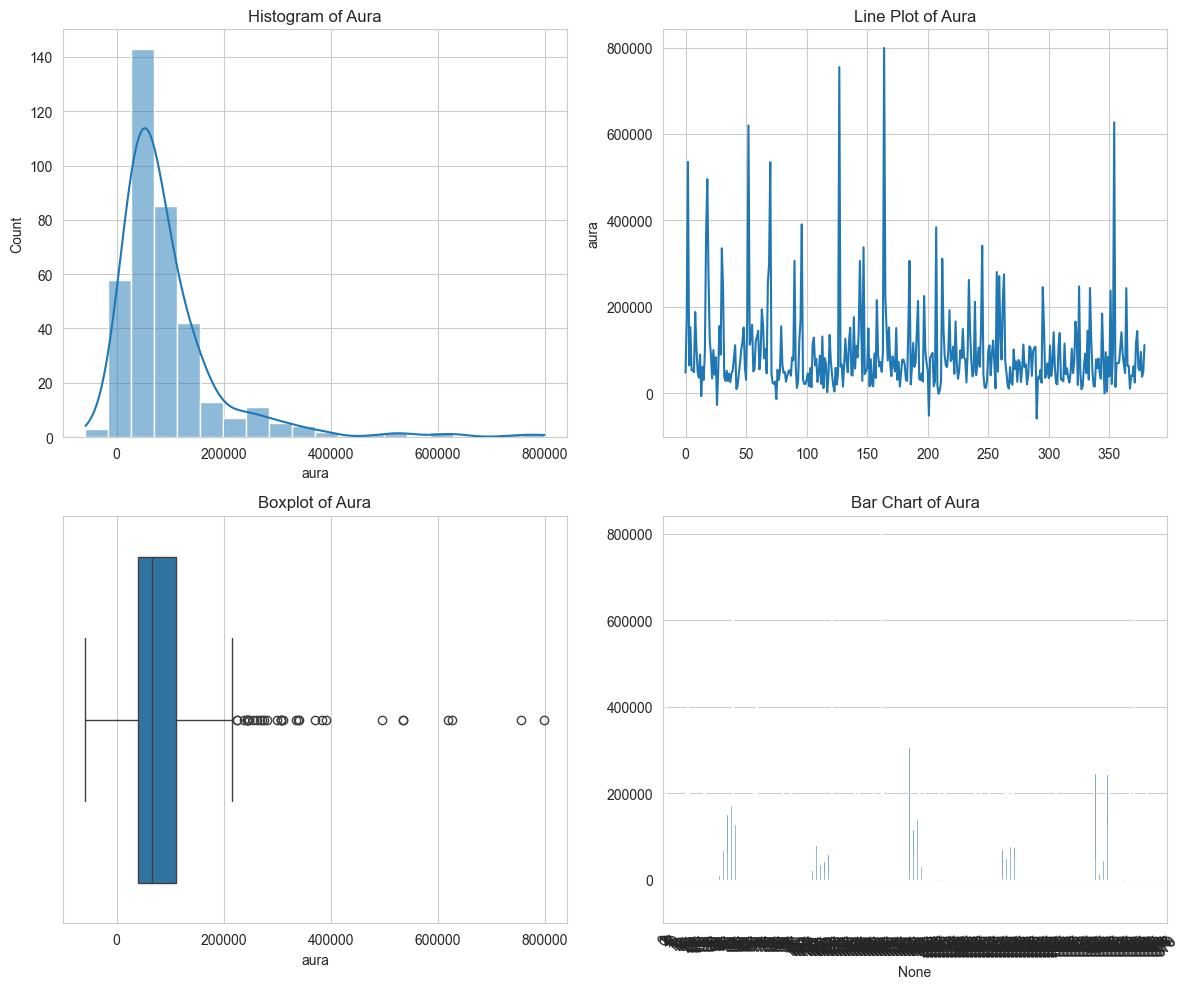

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming user_stats_df['aura'] is already available in the user's environment
aura_data = user_stats_df['aura']

# Set style
sns.set_style("whitegrid")

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Histogram
sns.histplot(aura_data, bins=20, kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Histogram of Aura")

# Line plot
sns.lineplot(data=aura_data, ax=axes[0, 1])
axes[0, 1].set_title("Line Plot of Aura")

# Boxplot
sns.boxplot(x=aura_data, ax=axes[1, 0])
axes[1, 0].set_title("Boxplot of Aura")

# Bar chart (Assuming categorical counts if aura is categorical)
if aura_data.dtype == 'object':
    sns.countplot(y=aura_data, ax=axes[1, 1])
else:
    sns.barplot(x=aura_data.index, y=aura_data.values, ax=axes[1, 1])
axes[1, 1].set_title("Bar Chart of Aura")

# Rotate x-labels for better visibility in bar chart
axes[1, 1].tick_params(axis='x', rotation=45)

# Adjust layout and show
plt.tight_layout()
plt.show()


In [ ]:
user_stats_df[['user', 'aura']].sort_values(by='aura').tail(50)

,user,aura
28,Casanovaa,155810.0
55,Georgie1471,158766.0
64,IRLKingsman,159263.0
322,sercanwinchester,165976.0
145,Wii_Gii,166148.0
223,finskbamse,166366.5
95,Nebko16,169265.5
1,0buddha,172951.0
51,Footstep_,173647.0
139,Vidke04,176311.5


In [ ]:
user_stats_df[['user', 'spam_count']].sort_values(by='spam_count').head(50)

,user,spam_count
303,raskolnik83,0.0
356,vincentvonbroccoli,0.0
101,P0P3_T,0.0
307,reshawator,0.0
293,per8immon,0.0
224,fkaGabe,0.0
97,Nightingale_______,0.0
343,the_great_lord_walden,0.0
196,d3wtwitchtvb,0.0
345,thejohnwack,0.0


In [ ]:
print(user_stats_df[['user', 'bit']].sort_values(by='bit').tail(10))

                         user   bit
325                  shogalul   450
197                   damm1jp   650
344              thebigdogjay   650
323                   shenxir  1275
3                    1SKELTON  1275
354                   uuccugr  1950
18   Aluminiumminimumimmunity  2125
139                   Vidke04  2375
305                 rebbel576  2725
30                CrazeE420xd  2975


In [ ]:
print(user_stats_df[['user', 'longest_streak']].sort_values(by='longest_streak').tail(50))

                         user  longest_streak
184                 catsspurr              30
330                smilodon_j              32
213                   emad_c7              32
289                   paaaat_              34
284                 noJokeee1              34
137                   Typhu25              34
161              astrologer95              35
17                    Aloddin              35
299                  purpcodd              35
79                   KrieSeaX              35
120                 Sacred1um              37
310             rodrigo_20771              37
322          sercanwinchester              37
325                  shogalul              38
68                IvanOnMyOwn              38
334                  stan_iv4              39
236                  gregg_69              39
229                    fuzok4              40
29                  ConorNewe              42
309               riesenklotz              42
153              adevogado0_0     

In [ ]:
# Assuming user_stats_df is your DataFrame
unique_words = user_stats_df['most_common_word_1'].unique()

# If you want to print them
print(unique_words)

['xqc32' 'LOL' 'ome44' 'omE' 'hi' 'I' 'how' 'mhm' 'Keepo' 'speed1' 'FEIN'
 '1' '!play' 'NOWAYING' 'hai' 'Joel' 'buh' '!boost' 'gn' 'doro' 'ome99'
 'PepeLaugh' 'paul' 'nt' 'no' 'omgBruh' 'English' 'LUL' 'lul' 'bro' 'qq'
 'cheerleaders' 'druskiDance' 'arnoldHalt' 'jah' 'jagger20LUL' 'im'
 'loeyaKEKW' 'BANGER' 'LULW' 'owoCheer' 'OMEGALUL' 'RaveTime' 'Nebko16'
 'tuah!' 'xD' 'bye' 'go' 'ReallyMad' '-' 'Listening' 'WW' 'classic' 'om'
 'Smurfing' 'dome37' 'lol' 'WatchingStream' '->' 'OOOO' 'Sadge' 'or'
 '@dorozea' ':D' 'game' 'aga' 'Banger' 'PagMan' 'What' 'SPOILER' 'ur'
 'erbyMariodance' 'Hai' 'dorozeaLOVE' 'ICANT' 'dorozeaHey' 'JARVIS'
 'BangbooBounce' 'chat' 'lmao' 'raid' 'Doro' 'xd' 'DORO' 'Yay' 'DinoDance'
 'finskbamse' 'dorozeaTouchingyou' 'klimzaOMEYES' 'ome32' 'omEE' 'WAJAJA'
 'YEP' 'an' 'Clap' 'BOOM' '😂😂😂' ':))' 'ome808' 'STREAMER' 'You' 'PagChomp'
 'applause' 'FeelsWowMan' 'paaaat_' 'peroni' 'LETSGO' 'mikuPls' 'Pffttt'
 'why' 'find' 'forsenE' 'RAID' 'dorozeaSlam' 'moustache' "it's" 

In [ ]:
# Assuming user_stats_df is your DataFrame
unique_words = user_stats_df['most_common_word_2'].unique()

# If you want to print them
print(unique_words)

['speed1' 'no' 'FEIN' 'bro' 'guys' 'This' 'yo' 'Pffttt' 'Sadding'
 'cheerleaders' 'EZ' '\U000e0000' 'DORO' 'FLASHBANG' 'LOL' 'mhm' 'ome44'
 'Tier' 'OOOO' 'hi' 'gg' 'I' 'IVANA' 'lol' 'qq' 'Im' 'jah' 'Joel' 'lmao'
 'Doro' 'hiii' 'bye' 'NODDERS' 'OMEGALUL' '@dorozea' 'LMAOFREAKY'
 'CaitThinking' 'Only' 'AREYOUAGIRL' 'LUL' "it's" '!play' 'im' 'TEAM'
 'Smurfing' 'nyanPls' 'dorozeaDoroScared' 'WutFace' 'ffeeveClap' 'BigSad'
 '))' 'om' 'ratomilton' 'kbgPls' 'LETSGO' 'WW' 'PepeLaugh' 'ICANT'
 'catAsk' '|' 'LO' 'good' 'DaRRa' 'used' 'catJAM' 'paul' 'DoroCheer'
 'owoCheer' 'YEP' 'Riyadh_z21' 'Xd' 'KKonaW' 'OMEYES' 'TITANHOLO'
 'WhySoSerious' 'VODs' 'PINK' '@Martin_Gales' 'stream' 'doro' 'omE' 'HUH'
 'You' 'BLOCK' 'hai' 'erbyLuigidance' '😭' 'dorozeaSlam' 'GoldPLZ' '@oJov'
 'ı' 'forsenPls' 'Kappa' 'yes' 'yeah' 'o7' 'muted' 'dorozeaDoroMock'
 'game' 'WideRaveTime' 'JinxLUL' 'how' 'Alarm' 'big' ':D' 'ur' ','
 'FeelsWowMan' 'Hi' 'dorozeaTouchingyou' '!boos' 'xd' 'DinoDance' 'ome96'
 'ome5' 'go' 'Hmm'

In [ ]:
# Assuming user_stats_df is your DataFrame
unique_words = user_stats_df['most_common_word_3'].unique()

# If you want to print them
print(unique_words)

['wideSpeedLaugh3' 'omE' '\U000e0000' 'XD' '!play' 'LOL' 'You'
 '@Martin_Gales' 'speed1' 'FEIN' 'I' 'xd' 'jah' 'TEAM' 'ome32' 'FEET'
 'SPOILER' 'An' 'What' 'ta' '!boost' 'LO' 'GO' 'dorozeaTouchingyou'
 "you're" 'OOOO' 'ome44' 'LUL' 'BANGER' 'bro' 'no' 'ome96' 'YEP'
 'Clueless' 'im' 'mhm' 'subscribed' 'nice' 'dorozeaDoroHuge' '[warning]'
 'doro' 'Cheer1000' 'om' 'see' 'Doro' 'up' 'bye' 'xar2EDM'
 'dorozeaDoroEvil' 'hesRight' 'Banger' 'me' 'daisyl3Nodders' 'o7' 'game'
 '<3' 'yea' 'aga' 'OMEGALUL' 'gg' 'yes' 'pepePoint' 'PepeLaugh' 'am' 'NO'
 'PogU' 'PAUSENEMOGU' 'or' 'gifted' 'Who' '+1' 'hi' 'Cinema'
 'TwitchConHYPE' 'has' ':D' "it's" 'plinkVibe' 'HUH' 'lol' 'happi' 'Tier'
 'hiii' 'Joel' '...' 'discord' 'fein' 'how' 'ur' 'xdd' 'DORO' '😭' 'LETSGO'
 '@dorozea' 'yyjPopcorn' 'ICANT' 'good' 'lets' 'BOOM' 'dorozeaAlert'
 'SeemsGood' 'PINK' ':(' 'play' '😂' 'F' 'why' 'caseohWiijams' 'gonna'
 'peepoHey' 'dorozeaDoroPogShake' 'go' 'BloodTrail' 'qq' 'whats' 'hai'
 'ome5' 'lmao' "I'm" 'OMEYES' 'PewP

In [ ]:
user_stats_df[user_stats_df['user']=='balintboss']

,user,total_messages,total_words,word_per_message,avg_message_per_stream,most_common_word_1,most_common_word_1_count,most_common_word_2,most_common_word_2_count,most_common_word_3,...,last_message_date,last_message_text,cheer,achievements,spam_count,words_result,warn_count,bit,gifts,aura
164,balintboss,44891,174706,3.891782,120.351206,I,3478,LOL,2459,TEAM,...,2025-07-21 21:12:03+02:00,bye bye,0,"[1, 1, 1, 1, 1]",1575.0,"[LOL, 2459, doroL, 1233, dome32, 1137]",4,0,0.0,799066.0


In [ ]:
user_stats_df[user_stats_df['user']=='Aluminiumminimumimmunity']

,user,total_messages,total_words,word_per_message,avg_message_per_stream,most_common_word_1,most_common_word_1_count,most_common_word_2,most_common_word_2_count,most_common_word_3,...,last_message_date,last_message_text,cheer,achievements,spam_count,words_result,warn_count,bit,gifts,aura
18,Aluminiumminimumimmunity,13108,41574,3.171651,36.512535,FEIN,4647,ome44,3376,SPOILER,...,2025-07-21 16:31:25+02:00,@balintboss Pffttt,20615,"[1, 1, 1, 0, 0]",1035.0,"[ome44, 3376, hi, 1105, bye, 1090]",40,2125,61.0,495454.0


In [ ]:
user_stats_df[user_stats_df['user']=='Typhu25']


,user,total_messages,total_words,word_per_message,avg_message_per_stream,most_common_word_1,most_common_word_1_count,most_common_word_2,most_common_word_2_count,most_common_word_3,...,last_message_date,last_message_text,cheer,achievements,spam_count,words_result,warn_count,bit,gifts,aura
137,Typhu25,26653,333204,12.501557,94.850534,FEIN,136992,ome44,50724,speed1,...,2025-07-15 19:41:12+02:00,ong i only work out to plump up my ass,510,"[1, 1, 1, 1, 0]",4386.0,"[ome44, 50724, speed1, 5712, ome52, 1533]",1,0,0.0,42717.0


In [ ]:
user_stats_df.nlargest(10, 'word_per_message')

,user,total_messages,total_words,word_per_message,avg_message_per_stream,most_common_word_1,most_common_word_1_count,most_common_word_2,most_common_word_2_count,most_common_word_3,...,last_message_date,last_message_text,cheer,achievements,spam_count,words_result,warn_count,bit,gifts,aura
105,PotatBotat,557,7932,14.240575,5.570000,-,607,used,290,has,...,2025-07-20 17:13:47+02:00,"󠀀🚫 Channel is currently live, and has configur...",0,"[0, 1, 0, 0, 0]",46.0,"[ome44, 94, speed1, 80, 7TV, 63]",0,0,0.0,114325.0
127,StreamElements,36233,487436,13.452819,97.139410,->,13036,VODs,9043,discord,...,2025-07-21 21:09:38+02:00,Want to keep the conversation going? Join the...,0,"[1, 1, 1, 1, 1]",669.0,"[WW, 2396, speed1, 1859, CS2, 1152]",0,0,0.0,754640.0
137,Typhu25,26653,333204,12.501557,94.850534,FEIN,136992,ome44,50724,speed1,...,2025-07-15 19:41:12+02:00,ong i only work out to plump up my ass,510,"[1, 1, 1, 1, 0]",4386.0,"[ome44, 50724, speed1, 5712, ome52, 1533]",1,0,0.0,42717.0
19,AnAnonymousGifter,1296,12962,10.001543,14.400000,1,1305,Tier,1296,An,...,2025-07-16 16:48:44+02:00,An anonymous user gifted a Tier 1 sub to Don_F...,0,"[1, 0, 0, 0, 0]",1018.0,"[None, 0, None, 0, None, 0]",0,0,1732.0,266882.0
52,Fossabot,7430,71564,9.631763,24.849498,English,6985,Only,6984,[warning],...,2025-07-21 21:12:25+02:00,"@chiandery13, English Only In Chat so mods can...",0,"[1, 1, 1, 1, 1]",6.0,"[mods, 5656, Chatting, 110, Dorozea, 8]",1,0,0.0,619768.0
294,peroni_nasturo_azuro,1735,15745,9.074928,25.895522,peroni,420,drink,146,man,...,2024-10-20 19:04:01+02:00,@1206paul_ i refreshed and the code isnt in ch...,0,"[1, 0, 1, 0, 0]",6.0,"[Pffttt, 31, ok, 19, life, 16]",0,0,0.0,24441.0
240,hanepirukas1,1216,10661,8.767270,33.777778,YEP,273,Hmm,90,then,...,2024-10-03 17:35:58+02:00,(fart),300,"[1, 0, 0, 0, 0]",5.0,"[YEP, 273, Hmm, 90, NODDERS, 43]",0,0,0.0,42226.0
182,captainmark2024,758,6476,8.543536,42.111111,LUL,101,I,96,it's,...,2025-03-15 16:40:06+01:00,trump: Doro must play for 10K in CS or it will...,0,"[0, 0, 0, 0, 0]",2.0,"[ok, 5, life, 5, hi, 4]",0,0,0.0,31040.0
111,Randy2D,1877,15444,8.228023,27.602941,LUL,587,I,448,lol,...,2025-07-15 20:57:16+02:00,Randy2D subscribed at Tier 1. They've subscrib...,0,"[0, 0, 0, 0, 0]",10.0,"[LOL, 85, bye, 41, ok, 31]",1,0,0.0,87177.0
95,Nebko16,663,4932,7.438914,28.826087,Nebko16,378,Tier,376,gifted,...,2025-07-12 01:59:24+02:00,bye doro and shat,16442,"[0, 0, 0, 0, 0]",318.0,"[!play, 11, bye, 5, o7, 4]",0,425,1178.0,169265.5


In [ ]:
user_stats_df.nlargest(10, 'total_streams')

,user,total_messages,total_words,word_per_message,avg_message_per_stream,most_common_word_1,most_common_word_1_count,most_common_word_2,most_common_word_2_count,most_common_word_3,...,last_message_date,last_message_text,cheer,achievements,spam_count,words_result,warn_count,bit,gifts,aura
127,StreamElements,36233,487436,13.452819,97.139410,->,13036,VODs,9043,discord,...,2025-07-21 21:09:38+02:00,Want to keep the conversation going? Join the...,0,"[1, 1, 1, 1, 1]",669.0,"[WW, 2396, speed1, 1859, CS2, 1152]",0,0,0.0,754640.0
164,balintboss,44891,174706,3.891782,120.351206,I,3478,LOL,2459,TEAM,...,2025-07-21 21:12:03+02:00,bye bye,0,"[1, 1, 1, 1, 1]",1575.0,"[LOL, 2459, doroL, 1233, dome32, 1137]",4,0,0.0,799066.0
18,Aluminiumminimumimmunity,13108,41574,3.171651,36.512535,FEIN,4647,ome44,3376,SPOILER,...,2025-07-21 16:31:25+02:00,@balintboss Pffttt,20615,"[1, 1, 1, 0, 0]",1035.0,"[ome44, 3376, hi, 1105, bye, 1090]",40,2125,61.0,495454.0
2,1206paul_,22675,121225,5.346196,64.785714,ome44,3989,FEIN,2525,󠀀,...,2025-07-21 20:59:29+02:00,MIKU mikuPls,200,"[1, 1, 1, 1, 0]",2008.0,"[ome44, 3989, LETSGO, 996, WW, 700]",0,0,1.0,535527.0
165,banties_x,39332,153205,3.895174,114.337209,speed1,8811,FEIN,7161,ome44,...,2025-07-21 19:08:58+02:00,typeshit,10,"[1, 1, 1, 1, 1]",4947.0,"[speed1, 8811, ome44, 6370, widetime, 2882]",3,400,7.0,225325.0
96,Nightbot,2608,18364,7.041411,7.903030,tuah!,446,|,432,Who,...,2025-07-21 20:59:03+02:00,The Best,0,"[1, 1, 0, 1, 0]",13.0,"[BUSSERS, 5, None, 0, None, 0]",0,0,0.0,390857.0
17,Aloddin,7831,43662,5.575533,24.095385,I,1222,mhm,1122,FEET,...,2025-07-16 18:34:23+02:00,@damm1jp It's America :),120,"[1, 1, 0, 1, 1]",158.0,"[mhm, 1122, o7, 317, GIGACHAIR, 234]",0,0,0.0,369897.0
147,Zeololz,6254,28419,4.544132,20.640264,aga,290,omE,269,ur,...,2025-07-21 21:11:34+02:00,broccoli are calling,0,"[1, 1, 1, 1, 0]",6.0,"[aga, 290, omE, 269, Smile, 144]",4,0,0.0,337803.0
262,klimzaa,22766,133191,5.850435,75.384106,ome44,12303,ome52,8155,fein,...,2025-07-21 21:08:52+02:00,gg bye bye,0,"[1, 1, 1, 1, 0]",1750.0,"[ome44, 12303, ome52, 8155, fein, 7668]",0,0,0.0,212864.0
52,Fossabot,7430,71564,9.631763,24.849498,English,6985,Only,6984,[warning],...,2025-07-21 21:12:25+02:00,"@chiandery13, English Only In Chat so mods can...",0,"[1, 1, 1, 1, 1]",6.0,"[mods, 5656, Chatting, 110, Dorozea, 8]",1,0,0.0,619768.0


In [ ]:
user_stats_df['total_streams'].describe()

count    380.000000
mean      75.078947
std       69.858841
min        3.000000
25%       29.000000
50%       52.500000
75%       96.250000
max      373.000000
Name: total_streams, dtype: float64

In [ ]:
user_stats_df.sort_values(by='last_message_date').head(25)

,user,total_messages,total_words,word_per_message,avg_message_per_stream,most_common_word_1,most_common_word_1_count,most_common_word_2,most_common_word_2_count,most_common_word_3,...,last_message_date,last_message_text,cheer,achievements,spam_count,words_result,warn_count,bit,gifts,aura
282,nevadasieera,519,2234,4.304432,47.181818,FeelsWowMan,37,FeelsBadMan,26,:O,...,2024-06-11 14:27:10+02:00,i called her friend and now she thinks she's n...,0,"[0, 0, 0, 0, 0]",0.0,"[FeelsWowMan, 37, FeelsBadMan, 26, BibleThump,...",0,0,0.0,20759.0
367,xxxflower1,791,2945,3.723135,79.100000,OMEGALUL,47,!play,24,PepeLaugh,...,2024-06-24 14:30:32+02:00,alright,0,"[0, 0, 0, 0, 0]",11.0,"[OMEGALUL, 47, !play, 24, PepeLaugh, 22]",0,0,0.0,11090.0
114,RealDrLing,661,2509,3.795764,73.444444,LUL,64,owoCheer,42,I,...,2024-06-24 21:14:23+02:00,bye,0,"[0, 0, 0, 0, 0]",12.0,"[owoCheer, 42, lmao, 8, OMEGALUL, 8]",0,0,10.0,12209.0
181,cake_for_me_,606,784,1.293729,16.833333,lol,52,yes,41,gg,...,2024-07-13 19:08:40+02:00,hi,0,"[0, 0, 0, 0, 0]",7.0,"[gg, 31, hi, 27, bye, 26]",0,0,0.0,66519.0
115,Risc__V,2908,10524,3.618982,48.466667,classic,156,YEP,132,bro,...,2024-07-24 18:24:00+02:00,CLOWNDETECTED,0,"[0, 0, 0, 0, 0]",5.0,"[classic, 156, YEP, 132, mhm, 66]",0,0,0.0,81337.0
125,SercanLeaxl,687,1578,2.296943,68.700000,WatchingStream,47,LOL,36,...,...,2024-08-01 15:48:36+02:00,#ad,0,"[0, 0, 0, 0, 0]",4.0,"[WatchingStream, 47, LOL, 36, !play, 12]",1,0,0.0,20259.0
244,icep1cke,1389,2282,1.642909,17.362500,Clap,295,EZ,120,!play,...,2024-08-09 20:48:43+02:00,!play 󠀀,100,"[0, 0, 0, 0, 0]",10.0,"[Clap, 295, EZ, 120, !play, 102]",0,0,10.0,147781.0
316,saadr223,678,3342,4.929204,23.379310,bro,53,!PLAY,27,game,...,2024-08-22 14:55:02+02:00,bro we use water,0,"[0, 0, 0, 0, 0]",3.0,"[arthur, 5, life, 3, gg, 2]",0,0,0.0,35903.0
43,EnthrallPain,589,3359,5.702886,53.545455,PepeLaugh,151,OMEGALUL,45,Clueless,...,2024-09-03 19:59:24+02:00,If you put ice behind your fan it's a mini ac ...,0,"[0, 0, 1, 0, 0]",1.0,"[PepeLaugh, 151, OMEGALUL, 45, Clueless, 45]",0,0,0.0,16912.0
215,enseje,1901,7808,4.107312,41.326087,xd,119,@Martin_Gales,94,@dorozea,...,2024-09-07 14:51:40+02:00,the forearms holy fuck,100,"[0, 0, 0, 0, 0]",2.0,"[xd, 119, mhm, 57, peepoLove, 50]",0,0,1.0,64109.0


In [ ]:
user_stats_df['buster_usage'].describe()

count    380.000000
mean       0.368421
std        1.471292
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       15.000000
Name: buster_usage, dtype: float64

In [ ]:
user_stats_df[['user', 'cheer']].sort_values(by='cheer').tail(50)

,user,cheer
334,stan_iv4,30
247,ileadarius27,90
310,rodrigo_20771,100
41,Drizzie3S,100
309,riesenklotz,100
57,Greksallad,100
139,Vidke04,100
215,enseje,100
244,icep1cke,100
295,phrank007,110


In [ ]:
user_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype                        
---  ------                    --------------  -----                        
 0   user                      380 non-null    object                       
 1   total_messages            380 non-null    int64                        
 2   total_words               380 non-null    int64                        
 3   word_per_message          380 non-null    float64                      
 4   avg_message_per_stream    380 non-null    float64                      
 5   most_common_word_1        380 non-null    object                       
 6   most_common_word_1_count  380 non-null    int64                        
 7   most_common_word_2        380 non-null    object                       
 8   most_common_word_2_count  380 non-null    int64                        
 9   most_common_word_3        380 non-null    o

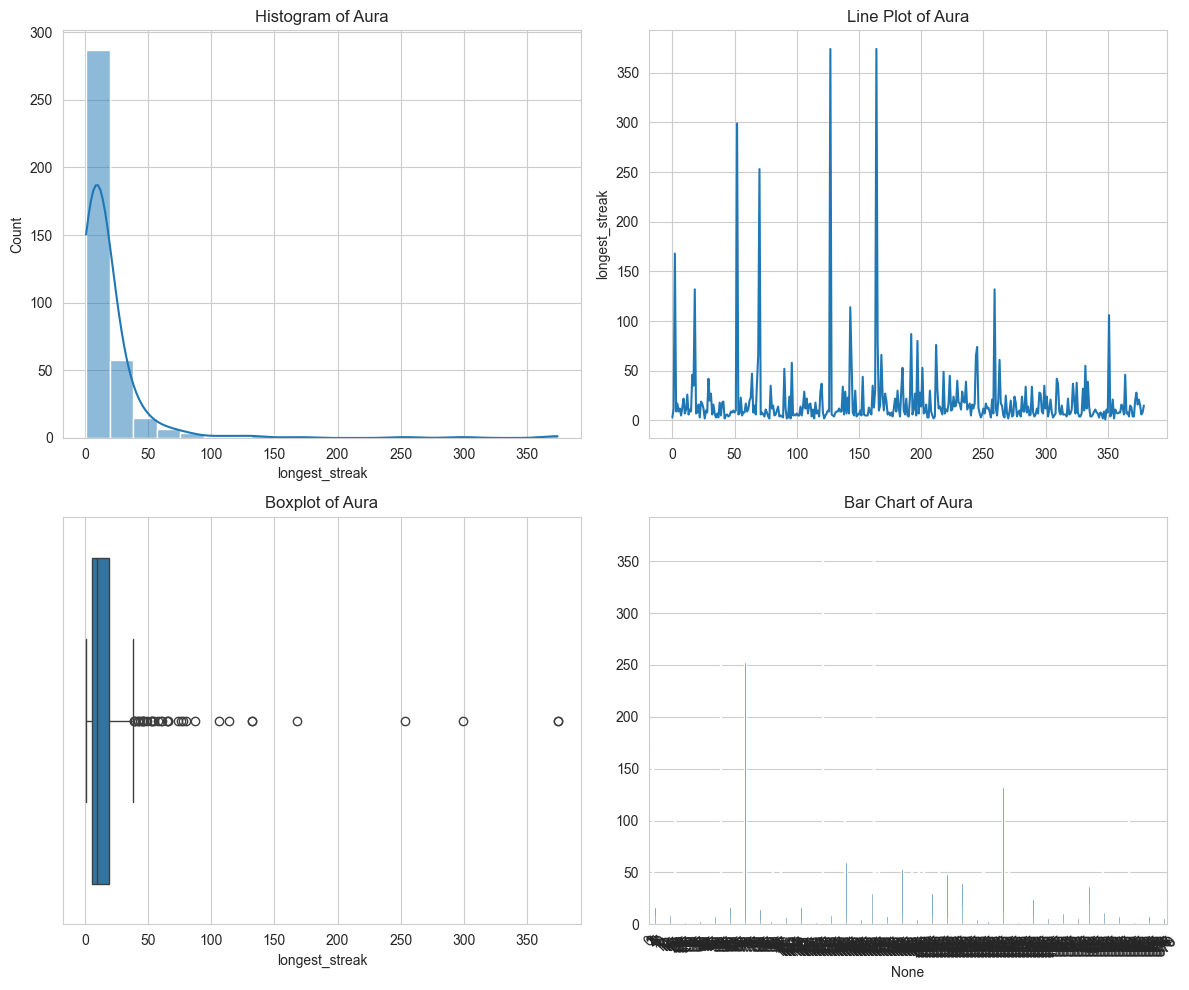

In [ ]:

# Assuming user_stats_df['aura'] is already available in the user's environment
longest_streak_data = user_stats_df['longest_streak']

# Set style
sns.set_style("whitegrid")

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Histogram
sns.histplot(longest_streak_data, bins=20, kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Histogram of Aura")

# Line plot
sns.lineplot(data=longest_streak_data, ax=axes[0, 1])
axes[0, 1].set_title("Line Plot of Aura")

# Boxplot
sns.boxplot(x=longest_streak_data, ax=axes[1, 0])
axes[1, 0].set_title("Boxplot of Aura")

# Bar chart (Assuming categorical counts if aura is categorical)
if longest_streak_data.dtype == 'object':
    sns.countplot(y=longest_streak_data, ax=axes[1, 1])
else:
    sns.barplot(x=longest_streak_data.index, y=longest_streak_data.values, ax=axes[1, 1])
axes[1, 1].set_title("Bar Chart of Aura")

# Rotate x-labels for better visibility in bar chart
axes[1, 1].tick_params(axis='x', rotation=45)

# Adjust layout and show
plt.tight_layout()
plt.show()


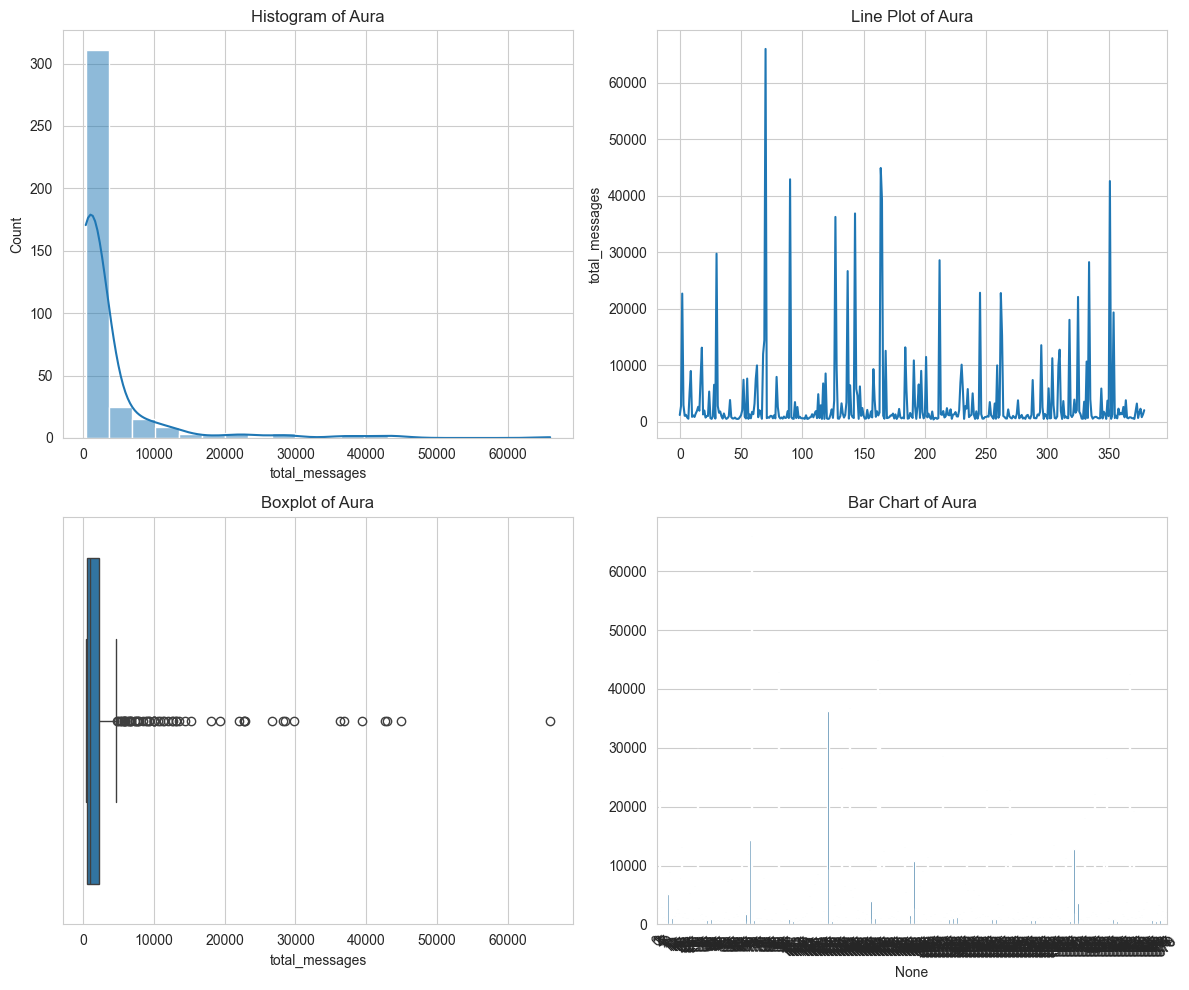

In [ ]:

# Assuming user_stats_df['aura'] is already available in the user's environment
total_streams = user_stats_df['total_messages']

# Set style
sns.set_style("whitegrid")

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Histogram
sns.histplot(total_streams, bins=20, kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Histogram of Aura")

# Line plot
sns.lineplot(data=total_streams, ax=axes[0, 1])
axes[0, 1].set_title("Line Plot of Aura")

# Boxplot
sns.boxplot(x=total_streams, ax=axes[1, 0])
axes[1, 0].set_title("Boxplot of Aura")

# Bar chart (Assuming categorical counts if aura is categorical)
if total_streams.dtype == 'object':
    sns.countplot(y=total_streams, ax=axes[1, 1])
else:
    sns.barplot(x=total_streams.index, y=total_streams.values, ax=axes[1, 1])
axes[1, 1].set_title("Bar Chart of Aura")

# Rotate x-labels for better visibility in bar chart
axes[1, 1].tick_params(axis='x', rotation=45)

# Adjust layout and show
plt.tight_layout()
plt.show()


In [ ]:
user_stats_df[['user', 'total_messages']].sort_values(by='total_messages').tail(50)

,user,total_messages
147,Zeololz,6254
139,Vidke04,6453
28,Casanovaa,6547
195,cukululu41,6602
117,Roonss,6783
229,fuzok4,6855
288,oJov,7383
52,Fossabot,7430
62,HoneyKick,7594
55,Georgie1471,7644


In [ ]:
user_stats_df['total_messages'].describe()

count      380.000000
mean      3449.260526
std       7263.074431
min        410.000000
25%        651.750000
50%       1052.500000
75%       2311.250000
max      65948.000000
Name: total_messages, dtype: float64

In [ ]:
user_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype                        
---  ------                    --------------  -----                        
 0   user                      380 non-null    object                       
 1   total_messages            380 non-null    int64                        
 2   total_words               380 non-null    int64                        
 3   word_per_message          380 non-null    float64                      
 4   avg_message_per_stream    380 non-null    float64                      
 5   most_common_word_1        380 non-null    object                       
 6   most_common_word_1_count  380 non-null    int64                        
 7   most_common_word_2        380 non-null    object                       
 8   most_common_word_2_count  380 non-null    int64                        
 9   most_common_word_3        380 non-null    o

In [ ]:
# Method 1: Select specific columns by name
selected_columns = ['user','mention_usage','mention_chater','total_messages', 'aura', 'total_words','most_common_word_1','most_common_word_2','most_common_word_3','total_streams','longest_streak','first_message_date','first_message_text','last_message_date','last_message_text','achivments','words_result']
subset_df = user_stats_df[selected_columns]



KeyError: "['achivments'] not in index"

In [ ]:
bots = ['StreamElements', 'Nightbot', 'fuzok4', 'riesenklotz', 'AnAnonymousGifter', 'Fossabot', 'peroni_nasturo_azuro']

subset_df = subset_df[~subset_df['user'].isin(bots)].reset_index(drop=True)

In [ ]:
# Export to json
#subset_df.to_json('usersdata.json', index=False)

subset_df.to_json("usersdata.json", orient="records", date_format="iso")

In [ ]:
def calculate_user_stats_optimized(df, data, words_list):
    """Calculates various statistics for each user (optimized)."""
    user_stats = []

    for user, user_df in df.groupby("user"):
        messages = user_df["message"].tolist()
        total_messages = len(messages)

        # Efficient total words
        total_words = user_df['message'].str.split().str.len().sum()
        word_per_message = total_words / total_messages if total_messages > 0 else 0

        # Efficient most common words
        all_messages = " ".join(messages)
        most_common_words = Counter(all_messages.split()).most_common(3)
        common_words = [word for word, _ in most_common_words] + [None] * (3 - len(most_common_words))
        common_counts = [count for _, count in most_common_words] + [0] * (3 - len(most_common_words))

        # Efficient keyword usage
        speed1_usage = user_df["message"].str.contains(r"\bspeed1\b", regex=True).sum()
        speed2_usage = user_df["message"].str.contains(r"\bspeed2\b", regex=True).sum()
        ome44_usage = user_df["message"].str.contains(r"\bome44\b", regex=True).sum()
        joel_usage = user_df["message"].str.contains(r"\bJoel\b", regex=True).sum()
        qq_usage = user_df["message"].str.contains(r"\bqq\b", regex=True).sum()
        boost_usage = user_df["message"].str.contains(r"\b!boost\b", regex=True).sum()
        smurf_usage = user_df["message"].str.contains(r"\bSmurfing\b", regex=True).sum()
        bleh_usage = user_df["message"].str.contains(r"\bBleh\b", regex=True).sum()
        play_usage = user_df["message"].str.contains('!play', regex=False).sum()
        buster_usage = user_df["message"].str.lower().str.contains('buster', regex=False).sum()
        peroni_usage = user_df["message"].str.lower().str.contains('peroni', regex=False).sum()
        fien_usage = user_df["message"].str.lower().str.contains('fien', regex=False).sum()
        mention_usage = user_df["message"].str.contains('@', regex=False).sum()
        mention_chater = data["message"].str.contains(user, regex=False).sum() # Careful with 'data' scope

        unique_streams = user_df["stream"].unique().tolist()

        first_message_date = user_df["date"].iloc[0]
        first_message_text = user_df["message"].iloc[0]
        last_message_date = user_df["date"].iloc[-1]
        last_message_text = user_df["message"].iloc[-1]

        # Identify streaks (can potentially be optimized further with vectorized diff)
        count = 1
        last = -1
        longest_streak = 1
        for e in unique_streams:
            if e == (last + 1):
                count += 1
                longest_streak = max(longest_streak, count)
            else:
                count = 1
            last = e

        # Apply the function to create a new column (try to avoid apply if possible)
        user_df["cheer_sum"] = user_df["message"].apply(extract_and_sum)
        cheer = user_df["cheer_sum"].sum()

        # Vectorized achievements
        stream_ids = [112, 184, 102, 177, 258]
        encoded_list = [1 if stream_id in user_df['stream'].values else 0 for stream_id in stream_ids]

        # Efficient filtered word count
        user_messages = user_df["message"].str.split()
        all_user_words = user_messages.explode()
        filtered_user_words = all_user_words[all_user_words.isin(words_list)]
        top_3_filtered = list(filtered_user_words.value_counts().nlargest(3).items())
        words_result = [item for sublist in top_3_filtered for item in sublist] + [None] * (6 - len(top_3_filtered) * 2)

        # Vectorized spam detection
        shifted_df = user_df.shift(1)
        time_diffs = (user_df['date'] - shifted_df['date']).dt.total_seconds()
        similarity = [SequenceMatcher(None, curr, prev).ratio() if pd.notna(prev) else 0
                      for prev, curr in zip(shifted_df['message'], user_df['message'])]
        spam_flag = (time_diffs <= 10) & (pd.Series(similarity) >= 0.6)
        spam_count = spam_flag.sum()

        user_stats.append({
            "user": user,
            "total_messages": total_messages,
            "total_words": total_words,
            "word_per_message": word_per_message,
            "avg_message_per_stream": total_messages / len(unique_streams) if unique_streams else 0,
            "most_common_word_1": common_words[0],
            "most_common_word_1_count": common_counts[0],
            "most_common_word_2": common_words[1],
            "most_common_word_2_count": common_counts[1],
            "most_common_word_3": common_words[2],
            "most_common_word_3_count": common_counts[2],
            "speed1_usage": speed1_usage,
            "speed2_usage": speed2_usage,
            "ome44_usage": ome44_usage,
            "joel_usage": joel_usage,
            "qq_usage": qq_usage,
            "bleh_usage": bleh_usage,
            "boost_usage": boost_usage,
            "buster_usage": buster_usage,
            "peroni_usage": peroni_usage,
            "fien_usage": fien_usage,
            "smurf_usage": smurf_usage,
            "play_usage": play_usage,
            "mention_usage": mention_usage,
            "mention_chater": mention_chater,
            "unique_streams": unique_streams,
            "total_streams": len(unique_streams),
            "longest_streak": longest_streak,
            "first_message_date": first_message_date,
            "first_message_text": first_message_text,
            "last_message_date": last_message_date,
            "last_message_text": last_message_text,
            "cheer": cheer,
            "achivments": encoded_list,
            "words_result": words_result,
            "spam_count": spam_count,
        })

    return pd.DataFrame(user_stats)

# Assuming 'data' and 'words_list' are defined elsewhere
#user_stats_df_optimized = calculate_user_stats_optimized(data_filtered.copy(), data, words_list)

#THIS IS NOT GOOD NOT CALCULATE THE GOOD THING IN IT

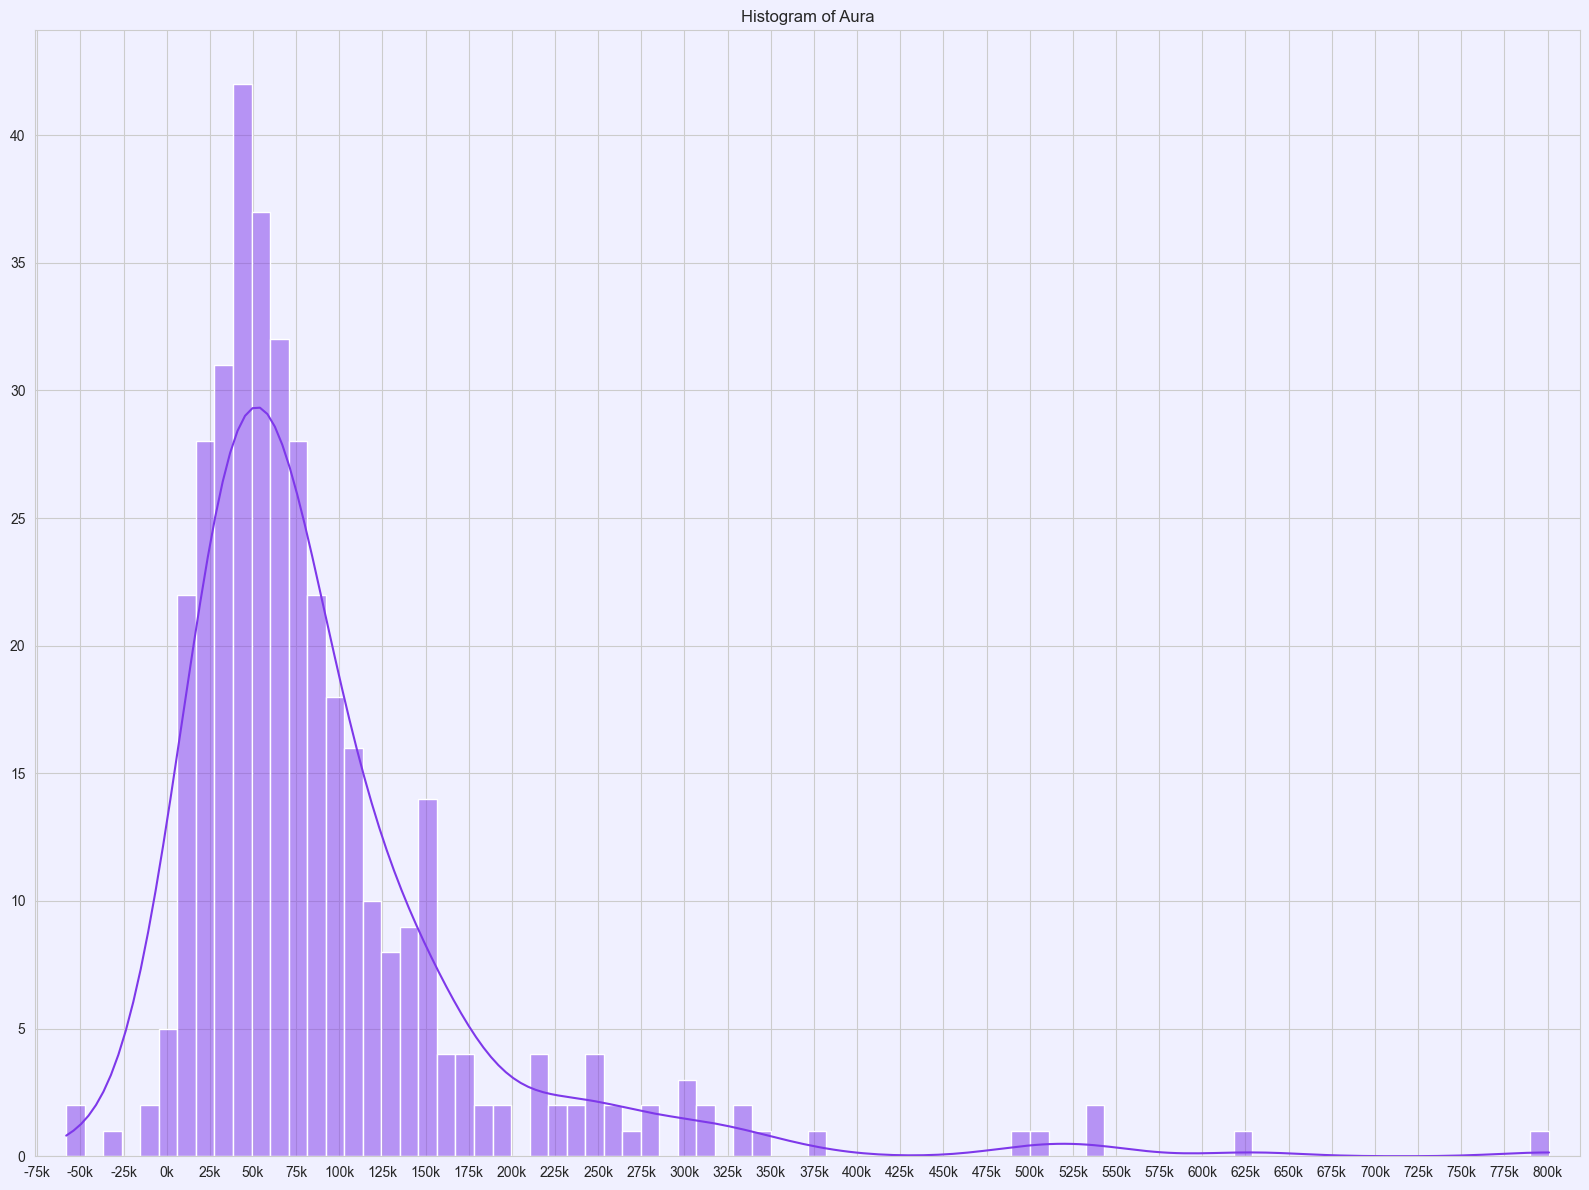

In [ ]:
aura_data = subset_df['aura']

# Set style
sns.set_style("whitegrid", {"axes.facecolor": "#F0F0FF", "figure.facecolor": "#F0F0FF"})

# Create a single figure
plt.figure(figsize=(16, 12))

# Histogram with KDE
sns.histplot(   aura_data,
                bins=80, 
                kde=True,
                fill=True,
                color='#7E38EA')
plt.title("Histogram of Aura")

# Format x-axis labels to show "k" notation every 25k
from matplotlib.ticker import FuncFormatter

def thousands_formatter(x, pos):
    return f'{int(x/1000)}k'

plt.gca().xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(25000))  # Set ticks every 25,000

# Get current x limits
x_min, x_max = plt.xlim()

# Adjust the limits to remove one tick from start and end
new_x_min = x_min + 25000
new_x_max = x_max - 25000
plt.xlim(new_x_min, new_x_max)

plt.xlabel("")  # Remove x-axis label
plt.ylabel("")  # Remove y-axis label

plt.tight_layout()
plt.show()


In [ ]:
aura_data.describe()

count       371.000000
mean      90304.874663
std       93914.966313
min      -58191.000000
25%       38980.000000
50%       64956.000000
75%      107813.000000
max      800836.000000
Name: aura, dtype: float64